#Clustering

Objetivo: crear diferentes clusterizaciones de los países según diferentes tipos de información que encontramos en las bases de datos de la FAO. En concreto hemos hecho 3 clusterizaciones para las cuales se han usado los siguientes datos:
Primera: Emisiones por sector (durante la cadena de suministro)
Segunda: Balance de alimentos (producción de alimentos, importación, exportación, etc.)
Tercera: Emisiones durante los procesos agrícolas y ganaderos.

Nota Importante: las gráficas no coinciden con las que se han mostrado en la presentación debido a que los notebooks se volvieron a ejecutar, dando como resultado diferentes clusters. Aunque se han creado clusters con los mismos países, el cluster que en la presentación era por ejemplo en número 0, en el Notebook puede que no tenga este mismo número de cluster.

##1. Carga de datos y librerias

###1.1. Importar drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###1.2. Importar librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import math
plt.style.use("ggplot")
from sklearn import model_selection 
from sklearn import metrics

# time calculation to track some processes
import time

# python core library for machine learning and data science
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans


### 1.3. Descargar ficheros csv

Descargamos ficheros con los datos que nos servirán para generar los diferentes clusters.

In [ ]:
df_emis_sec = pd.read_csv("/content/drive/MyDrive/Formació/MASTER NUCLIO/Capstone Project/datasets/Environment_Emissions_by_Sector_E_All_Data_(Normalized).zip (Unzipped Files)/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv", sep=",", encoding='latin-1')
df_alim = pd.read_csv("/content/drive/MyDrive/Formació/MASTER NUCLIO/Capstone Project/datasets/FoodBalanceSheets_E_All_Data_(Normalized)/FoodBalanceSheets_E_All_Data_(Normalized).csv", sep=",", encoding='latin-1')
df_emis_tot = pd.read_csv("/content/drive/MyDrive/Formació/MASTER NUCLIO/Capstone Project/datasets/Emissions_Totals_E_All_Data_(Normalized)/Emissions_Totals_E_All_Data_(Normalized).csv", sep=",", encoding='latin-1')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


####Tratado de Kioto.

Descargamos fichero csv con información sobre las agrupaciones de países que nos encontramos en las bases de datos de la FAO que estamos tratando. De este csv obtendremos información acerca de qué paises pertenecen al Anexo I del tratado de Kioto. Esta información ser usará posteriormente para la caracterización de los clusters. 


In [ ]:
# Descargamos el csv con info de agrupaciones de países. 

df_agrup_pais = pd.read_csv("/content/drive/MyDrive/Formació/MASTER NUCLIO/Capstone Project/datasets/Agrupaciones Paises.csv")
df_agrup_pais

,Country Group Code,Country Group,Country Code,Country,M49 Code,ISO2 Code,ISO3 Code
0,5100,Africa,4,Algeria,12.0,DZ,DZA
1,5100,Africa,7,Angola,24.0,AO,AGO
2,5100,Africa,53,Benin,204.0,BJ,BEN
3,5100,Africa,20,Botswana,72.0,BW,BWA
4,5100,Africa,233,Burkina Faso,854.0,BF,BFA
...,...,...,...,...,...,...,...
1964,5000,World,246,Yemen Ar Rp,886.0,NaN,NaN
1965,5000,World,247,Yemen Dem,720.0,NaN,NaN
1966,5000,World,248,Yugoslav SFR,890.0,NaN,NaN
1967,5000,World,251,Zambia,894.0,ZM,ZMB


A partir del Dataframe anterior, creamos un nuevo dataframe en el que cada file corresponda a un país y tenga una columna que indique con un 1 o un 0, si pertenece o no al Anexo I de Kioto. 

In [ ]:
df_agrup_pais["Country Group"].unique()

array(['Africa', 'Americas', 'Annex I countries', 'Antarctic Region',
       'Asia', 'Australia and New Zealand', 'Caribbean',
       'Caucasus and Central Asia', 'Central America', 'Central Asia',
       'Central Asia and Southern Asia', 'East Asia (excluding China)',
       'Eastern Africa', 'Eastern Asia',
       'Eastern Asia (excluding Japan and China)',
       'Eastern Asia (excluding Japan)',
       'Eastern Asia and South-eastern Asia', 'Eastern Europe', 'Europe',
       'European Union (27)', 'European Union (28)',
       'High-income economies', 'Land Locked Developing Countries',
       'Latin America and the Caribbean', 'Least Developed Countries',
       'Low income economies', 'Low Income Food Deficit Countries',
       'Lower-middle-income economies', 'Melanesia', 'Micronesia',
       'Middle Africa', 'Net Food Importing Developing Countries',
       'Non-Annex I countries', 'North Africa (excluding Sudan)',
       'Northern Africa', 'Northern America',
       'Northern 

In [ ]:
df_agrup_pais[df_agrup_pais["Country Group"]=="Annex I countries"].Country.unique()

array(['American Samoa', 'Anguilla', 'Aruba', 'Australia', 'Austria',
       'Belarus', 'Belgium', 'Belgium-Luxembourg', 'Bermuda',
       'British Virgin Islands', 'Bulgaria', 'Canada', 'Cayman Islands',
       'Channel Islands', 'Croatia', 'Cyprus', 'Czechia',
       'Czechoslovakia', 'Denmark', 'Estonia',
       'Falkland Islands (Malvinas)', 'Faroe Islands', 'Finland',
       'France', 'French Guyana', 'French Polynesia', 'Germany',
       'Gibraltar', 'Greece', 'Greenland', 'Guadeloupe', 'Guam',
       'Hungary', 'Iceland', 'Ireland', 'Isle of Man', 'Italy', 'Japan',
       'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta',
       'Martinique', 'Mayotte', 'Monaco', 'Montserrat', 'Netherlands',
       'Netherlands Antilles (former)', 'New Caledonia', 'New Zealand',
       'Norfolk Island', 'Northern Mariana Islands', 'Norway', 'Pitcairn',
       'Poland', 'Portugal', 'Puerto Rico', 'R?union', 'Romania',
       'Russian Federation',
       'Saint Helena, Ascension and Tr

In [ ]:
df_agrup_pais_transp = df_agrup_pais.pivot_table(index=["Country Code","Country"],columns="Country Group",values="Country Group Code",aggfunc="count").fillna(0)

In [ ]:
df_agrup_pais_transp.head(2)

,Country Group,Africa,Americas,Annex I countries,Antarctic Region,Asia,Australia and New Zealand,Caribbean,Caucasus and Central Asia,Central America,Central Asia,...,Southern Europe,Sub-Saharan Africa,Sub-Saharan Africa (including Sudan),Upper-middle-income economies,Western Africa,Western Asia,"Western Asia (exc. Armenia, Azerbaijan, Cyprus, Israel and Georgia)",Western Asia and Northern Africa,Western Europe,World
Country Code,Country,,,,,,,,,,,,,,,,,,,,,
1,Armenia,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,Afghanistan,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Comprobamos si lo ha hecho bien. Comparamos el número de países que pertenecen al Anexo I de la tabla inicial y el nuevo DataFrame.

df_agrup_pais_transp["Annex I countries"].sum()  == df_agrup_pais[df_agrup_pais["Country Group"]=="Annex I countries"].Country.nunique()

True

In [ ]:
df_paises_Kyoto = df_agrup_pais_transp[["Annex I countries"]]

In [ ]:
df_paises_Kyoto = df_paises_Kyoto.reset_index().rename(columns={"Country Code":"Area Code"})
df_paises_Kyoto.head()

Country Group,Area Code,Country,Annex I countries
0,1,Armenia,0.0
1,2,Afghanistan,0.0
2,3,Albania,0.0
3,4,Algeria,0.0
4,5,American Samoa,1.0


Descargamos el dataset que hemos creado a partir de la trade Matrix

#### Tabla de Información Macroeconomica. 
De esta tabla de la FAO vamos a obtener el PIB per cápita de cada país.

In [ ]:
df_macro = pd.read_csv("/content/drive/MyDrive/Formació/MASTER NUCLIO/Capstone Project/datasets/Macro-Statistics_Key_Indicators_E_All_Data_(Normalized)/Macro-Statistics_Key_Indicators_E_All_Data_(Normalized).csv", sep=",", encoding='latin-1')
df_macro.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,22008,Gross Domestic Product,6109,Value Local Currency,1970,1970,millions,77.911878,X,NaN
1,2,Afghanistan,22008,Gross Domestic Product,6109,Value Local Currency,1971,1971,millions,81.574837,X,NaN
2,2,Afghanistan,22008,Gross Domestic Product,6109,Value Local Currency,1972,1972,millions,74.152916,X,NaN
3,2,Afghanistan,22008,Gross Domestic Product,6109,Value Local Currency,1973,1973,millions,76.619555,X,NaN
4,2,Afghanistan,22008,Gross Domestic Product,6109,Value Local Currency,1974,1974,millions,92.774575,X,NaN


In [ ]:
# Vemos qué información hay en la base de datos.

df_macro.Item.unique()

array(['Gross Domestic Product', 'Gross Fixed Capital Formation',
       'Value Added (Agriculture, Forestry and Fishing)',
       'Value Added (Total Manufacturing)', 'Gross National Income',
       'Value Added (Manufacture of food, beverages and tobacco products)',
       'Value Added (Manufacture of food and beverages)',
       'Value Added (Manufacture of tobacco products)',
       'Gross Output (Agriculture, Forestry and Fishing)',
       'Value Added (Agriculture)', 'Gross Output (Agriculture)'],
      dtype=object)

In [ ]:
df_macro.Element.unique()

array(['Value Local Currency', 'Value US$', 'Value US$ per capita',
       'Value Local Currency, 2015 prices',
       'Value US$ per capita, 2015 prices', 'Value US$, 2015 prices',
       'Annual growth Local Currency',
       'Annual growth Local Currency, 2015 prices', 'Annual growth US$',
       'Annual growth US$ per capita', 'Annual growth US$, 2015 prices',
       'Annual growth US$ per capita, 2015 prices', 'Share of GDP US$',
       'Share of GDP US$, 2015 prices', 'Share of GDP Local Currency',
       'Share of GDP Local Currency, 2015 prices',
       'Ratio of Value Added (Agriculture, Forestry and Fishing) Local Currency',
       'Ratio of Value Added (Agriculture, Forestry and Fishing) US$',
       'Share of Value Added (Total Manufacturing) Local Currency',
       'Share of Value Added (Total Manufacturing) US$'], dtype=object)

In [ ]:
# Seleccionamos la información correspondiente al PIB. 

df_PIB = df_macro[df_macro["Item"] == "Gross Domestic Product"]

In [ ]:
df_PIB.Element.unique()

array(['Value Local Currency', 'Value US$', 'Value US$ per capita',
       'Value Local Currency, 2015 prices',
       'Value US$ per capita, 2015 prices', 'Value US$, 2015 prices',
       'Annual growth Local Currency',
       'Annual growth Local Currency, 2015 prices', 'Annual growth US$',
       'Annual growth US$ per capita', 'Annual growth US$, 2015 prices',
       'Annual growth US$ per capita, 2015 prices'], dtype=object)

In [ ]:
# Seleccionamos ahora el Pib per Cápita en US$. Este DataFrame se usará posteriormente cuando se realizan la caracterización de los clusters.

df_PIB_Dol_Cap = df_PIB[df_PIB["Element"] == 'Value US$ per capita']

### Tabla de Población

Bajamos la tabla de la FAO donde se encuentra la información de habitantes por país. Esta tabla se usará para obtener los datos per cápita que usaremos para crear los clusters.

In [ ]:
df_pop = pd.read_csv("/content/drive/MyDrive/Formació/MASTER NUCLIO/Capstone Project/datasets/Population_E_All_Data_(Normalized).zip (Unzipped Files)/Population_E_All_Data_(Normalized).csv", sep=",", encoding='latin-1')

Visualización del DataFrame

In [ ]:
df_pop.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1950,1950,1000 persons,7752.118,X,NaN
1,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1951,1951,1000 persons,7840.156,X,NaN
2,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1952,1952,1000 persons,7935.997,X,NaN
3,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1953,1953,1000 persons,8039.694,X,NaN
4,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1954,1954,1000 persons,8151.317,X,NaN


Vemos qué informaciones se guardan en la tabla.

In [ ]:
df_pop.Item.unique()

array(['Population - Est. & Proj.'], dtype=object)

In [ ]:
df_pop.Element.unique()

array(['Total Population - Both sexes', 'Total Population - Male',
       'Total Population - Female', 'Rural population',
       'Urban population'], dtype=object)

Usaremos la variable 'Total Population - Both sexes'

## Clustering por emisiones por sector (procesos en la cadena de suministro) **per cápita**


La primera clusterización la haremos a partir de los datos de emisiones por sector. Nota: Al principio del Notebook hemos bajado esta base de datos.

### Data Understanding. 

Hacemos un pequeño análisis de los datos buscando nulos y duplicados.

In [ ]:
# Vemos si hay duplicados

df_emis_sec[df_emis_sec.duplicated(keep=False)]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag


In [ ]:
# Vemos si hay nulos

df_emis_sec.isnull().sum()

Area Code       0
Area            0
Item Code       0
Item            0
Element Code    0
Element         0
Year Code       0
Year            0
Unit            0
Value           0
Flag            0
dtype: int64

Visualizamos los datos.

In [ ]:
df_emis_sec.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,6996,Farm-gate emissions,726313,Emissions Share (CO2eq) (AR5),1990,1990,%,80.2607,Fc
1,2,Afghanistan,6996,Farm-gate emissions,726313,Emissions Share (CO2eq) (AR5),1991,1991,%,80.8281,Fc
2,2,Afghanistan,6996,Farm-gate emissions,726313,Emissions Share (CO2eq) (AR5),1992,1992,%,86.8858,Fc
3,2,Afghanistan,6996,Farm-gate emissions,726313,Emissions Share (CO2eq) (AR5),1993,1993,%,86.1400,Fc
4,2,Afghanistan,6996,Farm-gate emissions,726313,Emissions Share (CO2eq) (AR5),1994,1994,%,85.3637,Fc


Visualizamos los tipos de datos que tenemos.

In [ ]:
df_emis_sec["Item"].unique()

array(['Farm-gate emissions', 'Land Use change',
       'Pre- and post- production', 'Fertilizers Manufacturing',
       'IPCC Agriculture', 'LULUCF', 'On-farm electricity use',
       'LULUCF - food systems', 'Energy', 'Food Processing',
       'Energy - food systems', 'Food Transport', 'IPPU', 'Food Retail',
       'Food Waste Disposal', 'Waste', 'Waste - food systems',
       'Food Household Consumption', 'Food Packaging',
       'All sectors with LULUCF', 'All sectors without LULUCF', 'Other',
       'Food systems', 'AFOLU', 'Emissions on agricultural land',
       'IPPU - food systems', 'Food Transport - International Bunkers',
       'International bunkers', 'International bunkers - food systems'],
      dtype=object)

Vemos que hay varias informaciones que son agrupaciones de otras, como  'All sectors with LULUCF' o 'All sectors without LULUCF'. Estas no las tendremos en cuenta en el cluster.

De los distintos valores de emisiones que hay en la base de datos para cada sector, usaremos el CO2 Equivalente ('Emissions Share (CO2eq) (AR5)').

In [ ]:
df_emis_sec["Element"].unique()

array(['Emissions Share (CO2eq) (AR5)', 'Emissions Share (CO2)',
       'Emissions Share (CH4)', 'Emissions Share (N2O)',
       'Emissions (CO2eq) (AR5)', 'Emissions (CO2)', 'Emissions (CH4)',
       'Emissions (N2O)', 'Emissions (F-gases)',
       'Emissions Share (F-gases)'], dtype=object)

Usaremos los datos de emisiones del último año para hacer los clusters.

In [ ]:
print("Ultimo año en la base de datos es:", df_emis_sec["Year"].max())

Ultimo año en la base de datos es: 2019


In [ ]:
# Creamos las variables auxiliares con el año y la variable con las emisiones que queremos usar para clusterizar

AÑO_CLUSTER = 2019
TARGET_ELEMENT = 'Emissions (CO2eq) (AR5)'

Filtramos el dataset. 

In [ ]:
# Seleccionamos el año 2019, el Elemento 'Emissions (CO2eq) (AR5)', y sólo los paises, no agrupaciones.

df_2019_CO2eq = df_emis_sec[(df_emis_sec["Year"]== AÑO_CLUSTER) & (df_emis_sec['Element']==TARGET_ELEMENT) & (df_emis_sec["Area Code"]<1000)]

In [ ]:
# Comprobamos que ha cogido bien el Elemento

df_2019_CO2eq.Element.unique()

array(['Emissions (CO2eq) (AR5)'], dtype=object)

In [ ]:
# Vemos los diferntes sectores.

df_2019_CO2eq.Item.unique()

array(['Farm-gate emissions', 'Land Use change',
       'Pre- and post- production', 'Fertilizers Manufacturing',
       'IPCC Agriculture', 'LULUCF', 'On-farm electricity use',
       'LULUCF - food systems', 'Energy', 'Food Processing',
       'Energy - food systems', 'Food Transport', 'IPPU', 'Food Retail',
       'Food Waste Disposal', 'Waste', 'Waste - food systems',
       'Food Household Consumption', 'Food Packaging',
       'All sectors with LULUCF', 'All sectors without LULUCF', 'Other',
       'Food systems', 'AFOLU', 'Emissions on agricultural land',
       'IPPU - food systems'], dtype=object)

In [ ]:
#  Visualizamos el dataaset filtrado

df_2019_CO2eq.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
149,2,Afghanistan,6996,Farm-gate emissions,723113,Emissions (CO2eq) (AR5),2019,2019,kilotonnes,16471.2413,Fc
419,2,Afghanistan,6516,Land Use change,723113,Emissions (CO2eq) (AR5),2019,2019,kilotonnes,0.0000,Fc
689,2,Afghanistan,6517,Pre- and post- production,723113,Emissions (CO2eq) (AR5),2019,2019,kilotonnes,4435.8857,A
899,2,Afghanistan,6504,Fertilizers Manufacturing,723113,Emissions (CO2eq) (AR5),2019,2019,kilotonnes,23.2331,Fc
1109,2,Afghanistan,1711,IPCC Agriculture,723113,Emissions (CO2eq) (AR5),2019,2019,kilotonnes,16342.7221,A


In [ ]:
# Hacemos pivot table para poner los Items como columnas

df_2019_CO2eq_transp = df_2019_CO2eq.pivot_table(index="Area",columns="Item",values="Value",aggfunc="mean")
df_2019_CO2eq_transp.head(2)

Item,AFOLU,All sectors with LULUCF,All sectors without LULUCF,Emissions on agricultural land,Energy,Energy - food systems,Farm-gate emissions,Fertilizers Manufacturing,Food Household Consumption,Food Packaging,...,IPPU,IPPU - food systems,LULUCF,LULUCF - food systems,Land Use change,On-farm electricity use,Other,Pre- and post- production,Waste,Waste - food systems
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,16497.3795,33078.4675,32923.8101,16471.2413,10612.83,1061.0057,16471.2413,23.2331,486.4140,12.1979,...,308.968,NaN,154.6574,0.0000,0.0,43.9521,89.040,4435.8857,5570.25,3503.3924
Albania,2698.4834,9346.2664,9584.1457,3404.1936,4954.57,978.4455,3404.1936,NaN,181.1625,19.2829,...,1115.118,98.0501,-237.8793,114.1346,0.0,5.8923,33.125,1408.5844,544.97,685.7718


In [ ]:
# Miramos si se han creado nulos

df_2019_CO2eq_transp.isnull().sum()

Item
AFOLU                               1
All sectors with LULUCF             1
All sectors without LULUCF          1
Emissions on agricultural land      0
Energy                             28
Energy - food systems               3
Farm-gate emissions                 0
Fertilizers Manufacturing         165
Food Household Consumption          5
Food Packaging                     29
Food Processing                    28
Food Retail                        11
Food Transport                     21
Food Waste Disposal                 4
Food systems                        0
IPCC Agriculture                    1
IPPU                               28
IPPU - food systems               133
LULUCF                              1
LULUCF - food systems               1
Land Use change                     1
On-farm electricity use            10
Other                              32
Pre- and post- production           2
Waste                              27
Waste - food systems                4
dtype: 

Se han creado nulos al hacer la pivot_table, que significa que para esas variables no había ningún registro. En algunos como "Fertilizers Manufacturing" hay muchos nulos, pero podría ser que no todos los países tengan la capacidad de fabricar fertilizantes o la cantidad es muy pequeña. En este caso optamos por rellenarlos con 0's.

Estos nulos se han creado al generar la pivot_table, Hay algunos Elmentos que deberían de tener información, como la variable "Energy". a parte de la variable "Fertilizers Manufacturing", imputaremos los nulos con el algortimo KNN, aunque hay algunas variables con tantos nulos que no sé sería la mejor opción.

En el caso del "IPPU - Food systems", tiene muchísimos nulos, y decidimos eliminar esta variable.

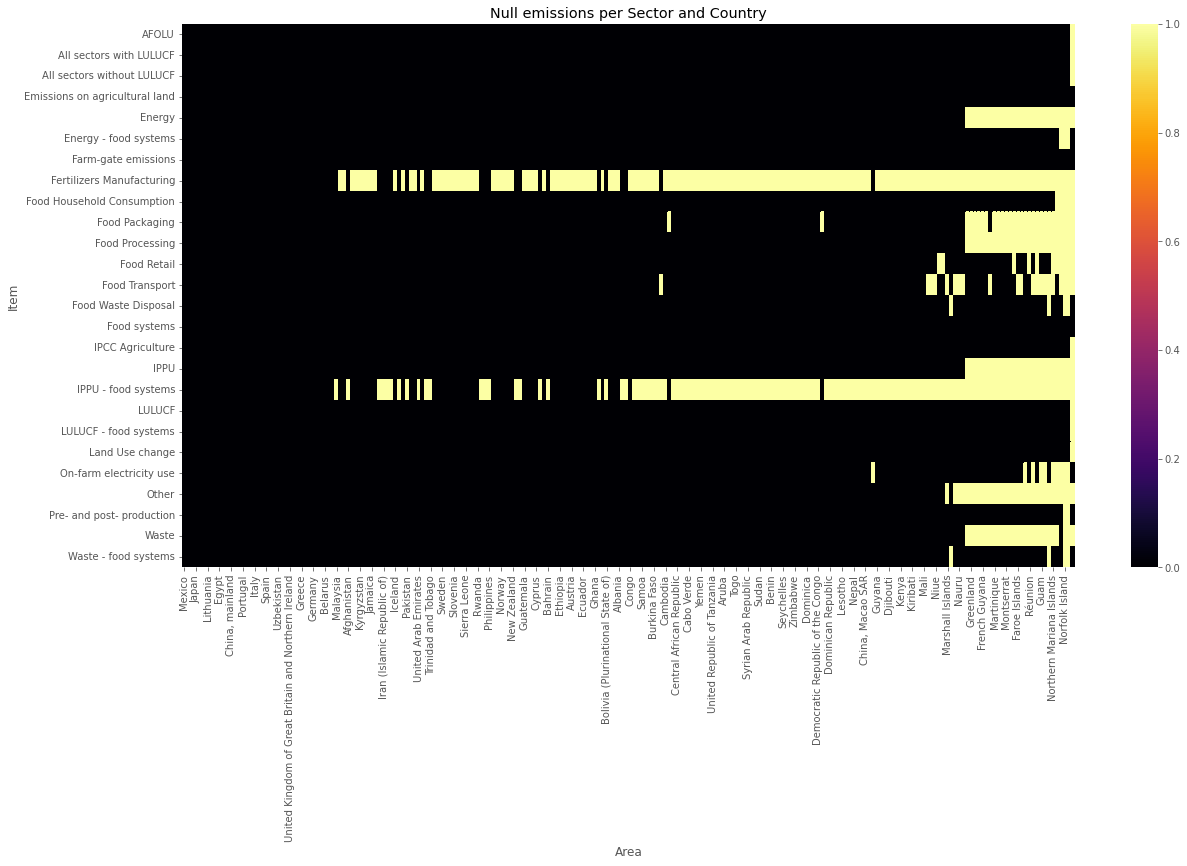

In [ ]:
# Observamos los nulos (Estamos sólo con los datos del último año)

gb_df_ = df_2019_CO2eq_transp.isnull().T
order_of_columns = list(gb_df_.sum().sort_values().index)
gb_df_ = gb_df_[order_of_columns]

plt.figure(figsize = (20, 10))
plot = sns.heatmap(gb_df_, cbar = True, cmap = "inferno")
plot.set_title("Null emissions per Sector and Country");

In [ ]:
# Vemos el número de filas y columnas tenemos (es decir, paises y sectores respectivamente)
df_2019_CO2eq_transp.shape

(228, 26)

Procedemos a imputar los nulos a la variable 'Fertilizers Manufacturing' y eliminamos la "IPPU - food systems"

In [ ]:
VAR_TO_DROP = ["IPPU - food systems"]

In [ ]:
df_clust = df_2019_CO2eq_transp.drop(VAR_TO_DROP, axis=1)

In [ ]:
df_clust['Fertilizers Manufacturing'].fillna(0, inplace=True)

In [ ]:
# VEmos de nuevo los nulos que nos quedan.

df_clust.isnull().sum()

Item
AFOLU                              1
All sectors with LULUCF            1
All sectors without LULUCF         1
Emissions on agricultural land     0
Energy                            28
Energy - food systems              3
Farm-gate emissions                0
Fertilizers Manufacturing          0
Food Household Consumption         5
Food Packaging                    29
Food Processing                   28
Food Retail                       11
Food Transport                    21
Food Waste Disposal                4
Food systems                       0
IPCC Agriculture                   1
IPPU                              28
LULUCF                             1
LULUCF - food systems              1
Land Use change                    1
On-farm electricity use           10
Other                             32
Pre- and post- production          2
Waste                             27
Waste - food systems               4
dtype: int64

Hay varias variables con el mismo número de nulos. Vemos a qué paises corresponden. Creamos una pequeña función para ello.

In [ ]:
def ver_nulos_columna(df,col):
  return df[df[col].isnull()][col]


In [ ]:
ver_nulos_columna(df_clust,'Food Packaging')

Area
American Samoa                 NaN
Bermuda                        NaN
Cayman Islands                 NaN
Channel Islands                NaN
Falkland Islands (Malvinas)    NaN
Faroe Islands                  NaN
French Guyana                  NaN
French Polynesia               NaN
Gibraltar                      NaN
Greenland                      NaN
Guadeloupe                     NaN
Guam                           NaN
Isle of Man                    NaN
Madagascar                     NaN
Martinique                     NaN
Mayotte                        NaN
Montserrat                     NaN
New Caledonia                  NaN
Norfolk Island                 NaN
Northern Mariana Islands       NaN
Pitcairn                       NaN
Puerto Rico                    NaN
Republic of Moldova            NaN
Réunion                        NaN
Saint Pierre and Miquelon      NaN
Tokelau                        NaN
United States Virgin Islands   NaN
Wallis and Futuna Islands      NaN
Western Sahara 

In [ ]:
ver_nulos_columna(df_clust,'IPPU')

Area
American Samoa                 NaN
Bermuda                        NaN
Cayman Islands                 NaN
Channel Islands                NaN
Falkland Islands (Malvinas)    NaN
Faroe Islands                  NaN
French Guyana                  NaN
French Polynesia               NaN
Gibraltar                      NaN
Greenland                      NaN
Guadeloupe                     NaN
Guam                           NaN
Isle of Man                    NaN
Martinique                     NaN
Mayotte                        NaN
Montserrat                     NaN
New Caledonia                  NaN
Norfolk Island                 NaN
Northern Mariana Islands       NaN
Palestine                      NaN
Pitcairn                       NaN
Puerto Rico                    NaN
Réunion                        NaN
Saint Pierre and Miquelon      NaN
Tokelau                        NaN
United States Virgin Islands   NaN
Wallis and Futuna Islands      NaN
Western Sahara                 NaN
Name: IPPU, dty

In [ ]:
ver_nulos_columna(df_clust,'Energy')

Area
American Samoa                 NaN
Bermuda                        NaN
Cayman Islands                 NaN
Channel Islands                NaN
Falkland Islands (Malvinas)    NaN
Faroe Islands                  NaN
French Guyana                  NaN
French Polynesia               NaN
Gibraltar                      NaN
Greenland                      NaN
Guadeloupe                     NaN
Guam                           NaN
Isle of Man                    NaN
Martinique                     NaN
Mayotte                        NaN
Montserrat                     NaN
New Caledonia                  NaN
Norfolk Island                 NaN
Northern Mariana Islands       NaN
Palestine                      NaN
Pitcairn                       NaN
Puerto Rico                    NaN
Réunion                        NaN
Saint Pierre and Miquelon      NaN
Tokelau                        NaN
United States Virgin Islands   NaN
Wallis and Futuna Islands      NaN
Western Sahara                 NaN
Name: Energy, d

Se repiten los mismos paiese, que són básicamente islas. Lo imputaremos por KNN.

Antes, los guardamos en una lista, para ver qué valores se les imputan.

In [ ]:
indices_nulls = ver_nulos_columna(df_clust,'Energy').index

Para realizar el clustering lo haremos con una pipeline. Para ello, declaramos a continuación algunas funciones que crean transformers para ser usados en dicho pipeline.

In [ ]:
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    '''
    Clase que transforma un array en un DataFrame.
    Necesita como parámetros el nombre de las columnas y el índice.
    '''
    
    def __init__(self, columns, index = None):
        self.columns = columns
        self.index = index
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        if self.index != None:
            df = pd.DataFrame(X, columns = self.columns, index = self.index)
            
        else:
            df = pd.DataFrame(X, columns = self.columns)
            
        return df

Creamos transformer para eliminar outliers (Extraído del Notebook de Nico)

In [ ]:
## Hay que indicar la lista de variables a clipear.

class OutlierFilter(BaseEstimator, TransformerMixin):
    '''
    Clase que filtra los outliers utilizando np.quantile()
    Los cuantiles a filtrar así como las columnas a filtrar son los parámetros de la clase.
    '''
    
    def __init__(self, q, col_to_filter):
        self.q = q
        self.col_to_filter = col_to_filter
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        '''
        El método considera outlier a aquel cliente que es outlier en todas las columnas que le pasas.
        Es decir: si tiene que filtrar importe y número de pedidos, sólo va a eliminar aquellos clientes
        que son outlier tanto en importe como número de pedidos. Si eres outlier en importe pero no en pedido
        no se te va a filtrar del dataset.
        '''
        
        # lista vacía
        criteria_list = []
        
        # agregamos a la lista los clientes que son outliers
        for col in self.col_to_filter:
            criteria = X[col] < np.quantile(X[col], q = self.q)
            criteria_list.append(criteria)
            
        # si hay más de 1 columna
        if len(self.col_to_filter) > 1:
            
            # creamos el criterio global: es decir outlier en todas las columnas
            global_criteria = criteria_list[0]
            
            for criteria in criteria_list[1:]:
                global_criteria = global_criteria & criteria
                
        else:
            global_criteria = criteria_list[0]
            
        # filtramos nuestra dataframe
        X = X[global_criteria]
        
        # guardamos el índice como parámetro de la clase porque en caso contrario lo perderíamos.
        self.index = X.index
        
        return X

Creamos el KNN imputer para hacer una prueba y ver qué valores imputa.

In [ ]:
imputer = KNNImputer()

In [ ]:
imputer.fit(df_clust)

KNNImputer()

In [ ]:
df_clust_imputed = pd.DataFrame(imputer.transform(df_clust), columns = df_clust.columns, index = df_clust.index)


Comprobamos los nulos que ha puesto.

In [ ]:
df_clust_imputed.loc[indices_nulls]['Energy']

Area
American Samoa                    41.93084
Bermuda                           41.93084
Cayman Islands                    41.06178
Channel Islands                  101.91800
Falkland Islands (Malvinas)      432.02606
Faroe Islands                    169.16942
French Guyana                    715.85990
French Polynesia                 112.67894
Gibraltar                         41.93084
Greenland                         41.06178
Guadeloupe                       238.03470
Guam                              41.93084
Isle of Man                       41.93084
Martinique                        96.37038
Mayotte                           41.93084
Montserrat                        41.93084
New Caledonia                    248.02138
Norfolk Island                    41.93084
Northern Mariana Islands         254.00064
Palestine                        368.83212
Pitcairn                          41.93084
Puerto Rico                     1260.69568
Réunion                          286.67668
Saint 

Vempos que ha tratado de diferente manera a Puetro Rico y otros países, y ha puesto el mismo valor en países muy pequeños.

In [ ]:
df_clust_imputed.loc[indices_nulls]['Food Packaging']

Area
American Samoa                  0.02242
Bermuda                         0.02242
Cayman Islands                  0.02454
Channel Islands                 0.07788
Falkland Islands (Malvinas)     0.21808
Faroe Islands                   0.09738
French Guyana                   0.23064
French Polynesia                0.06618
Gibraltar                       0.02242
Greenland                       0.02454
Guadeloupe                      0.11262
Guam                            0.02242
Isle of Man                     0.02242
Martinique                      0.04342
Mayotte                         0.02242
Montserrat                      0.02242
New Caledonia                   0.14762
Norfolk Island                  0.02242
Northern Mariana Islands        0.14632
Palestine                       0.32510
Pitcairn                        0.02242
Puerto Rico                     0.81664
Réunion                         0.13228
Saint Pierre and Miquelon       0.02242
Tokelau                         0.0

En el caso del Food Packagin ha puesto valores prácticamente a 0 en todos los países.

### Añadimos la población al dataset de emisiones

In [ ]:
print(df_clust.shape)

(228, 25)


In [ ]:
# Vemos la información que hay en la base de datos de la población.

df_pop.Element.unique()

array(['Total Population - Both sexes', 'Total Population - Male',
       'Total Population - Female', 'Rural population',
       'Urban population'], dtype=object)

Usaremos la variable 'Total Population - Both sexes'

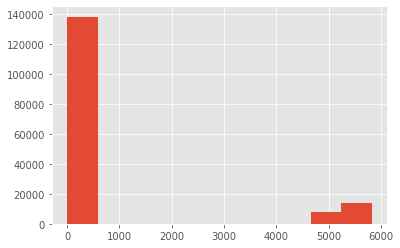

In [ ]:
# Hay agrupaciones de paises? Si

df_pop["Area Code"].hist()

Filtramos el dataset y nos quedamos los datos del año 2019, la población total incluyendo ambos sexos y sólo los países, no las agrupaciones.

In [ ]:
df_pop_both_2019 = df_pop[(df_pop.Element == 'Total Population - Both sexes') & (df_pop.Year == 2019) & (df_pop["Area Code"] < 1000)]
print(df_pop_both_2019.shape)


(237, 12)


In [ ]:
df_pop_both_2019.columns

Index(['Area Code', 'Area', 'Item Code', 'Item', 'Element Code', 'Element',
       'Year Code', 'Year', 'Unit', 'Value', 'Flag', 'Note'],
      dtype='object')

In [ ]:
df_pop_both_2019.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
69,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2019,2019,1000 persons,38041.754,X,NaN
724,3,Albania,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2019,2019,1000 persons,2880.917,X,NaN
1379,4,Algeria,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2019,2019,1000 persons,43053.054,X,NaN
2034,5,American Samoa,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2019,2019,1000 persons,55.312,X,NaN
2387,6,Andorra,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2019,2019,1000 persons,77.142,X,NaN


In [ ]:
# Hacemos pivot table para crear un Dataframe con la información en el formato deseado, para poder hacer un merge posteriormente con la tabla de las emisiones.

df_pop_both_2019_pivot = df_pop_both_2019.pivot_table(index="Area",columns="Element",values="Value",aggfunc="mean")

In [ ]:
# Comprobamos que está bien.

df_pop_both_2019_pivot.head()

Element,Total Population - Both sexes
Area,
Afghanistan,38041.754
Albania,2880.917
Algeria,43053.054
American Samoa,55.312
Andorra,77.142


In [ ]:
# En la tabla de poblacion hay más Areas que en la de Emisiones. Haremos un merge left de la tabla de emisiones, para que no falte ningun Area
print(df_clust.shape)
df_emis_pop_2019 = pd.merge(df_clust, df_pop_both_2019_pivot, on = "Area", how="left")
print(df_emis_pop_2019.shape)

(228, 25)
(228, 26)


In [ ]:
# Comprobamos si hay alguna fila que no se le ha podido asignar población.

df_emis_pop_2019[df_emis_pop_2019["Total Population - Both sexes"].isnull()]

,AFOLU,All sectors with LULUCF,All sectors without LULUCF,Emissions on agricultural land,Energy,Energy - food systems,Farm-gate emissions,Fertilizers Manufacturing,Food Household Consumption,Food Packaging,...,IPPU,LULUCF,LULUCF - food systems,Land Use change,On-farm electricity use,Other,Pre- and post- production,Waste,Waste - food systems,Total Population - Both sexes
Area,,,,,,,,,,,,,,,,,,,,,
Norfolk Island,0.1275,0.1275,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,0.1275,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
Pitcairn,0.0000,0.0000,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,0.0000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
 ## Estos dos países se podrían eliminar porque está prácticamente todos sus variables a 0 o Nulos!

In [ ]:
df_emis_pop_2019 = df_emis_pop_2019.drop(index=["Pitcairn", "Norfolk Island"])

In [ ]:
df_emis_pop_2019.shape

(226, 26)

In [ ]:
df_emis_pop_2019.columns

Index(['AFOLU', 'All sectors with LULUCF', 'All sectors without LULUCF',
       'Emissions on agricultural land', 'Energy', 'Energy - food systems',
       'Farm-gate emissions', 'Fertilizers Manufacturing',
       'Food Household Consumption', 'Food Packaging', 'Food Processing',
       'Food Retail', 'Food Transport', 'Food Waste Disposal', 'Food systems',
       'IPCC Agriculture', 'IPPU', 'LULUCF', 'LULUCF - food systems',
       'Land Use change', 'On-farm electricity use', 'Other',
       'Pre- and post- production', 'Waste', 'Waste - food systems',
       'Total Population - Both sexes'],
      dtype='object')

Comprobamos la correlación entre ellos, antes de dividir.

In [ ]:
corr = df_emis_pop_2019.corr()
corr.style.background_gradient(cmap="coolwarm")


,AFOLU,All sectors with LULUCF,All sectors without LULUCF,Emissions on agricultural land,Energy,Energy - food systems,Farm-gate emissions,Fertilizers Manufacturing,Food Household Consumption,Food Packaging,Food Processing,Food Retail,Food Transport,Food Waste Disposal,Food systems,IPCC Agriculture,IPPU,LULUCF,LULUCF - food systems,Land Use change,On-farm electricity use,Other,Pre- and post- production,Waste,Waste - food systems,Total Population - Both sexes
AFOLU,1.000000,0.175428,0.111928,0.809700,0.075557,0.110303,0.563273,0.031226,0.098742,-0.002041,0.081494,-0.053211,0.283798,0.403276,0.578358,0.509808,0.024330,0.695902,0.848928,0.838825,0.289703,0.172253,0.173485,0.245806,0.403276,0.323960
All sectors with LULUCF,0.175428,1.000000,0.997571,0.661902,0.995266,0.981246,0.857622,0.966730,0.967101,0.950737,0.378272,0.379544,0.828385,0.928533,0.877989,0.835568,0.981959,-0.500764,0.133283,0.117577,0.729292,0.978967,0.975157,0.973023,0.928533,0.905766
All sectors without LULUCF,0.111928,0.997571,1.000000,0.616728,0.998884,0.986020,0.835950,0.973308,0.970350,0.956950,0.379952,0.389228,0.820947,0.915710,0.851063,0.821033,0.987657,-0.559844,0.070423,0.056825,0.728377,0.979162,0.976462,0.969006,0.915710,0.899608
Emissions on agricultural land,0.809700,0.661902,0.616728,1.000000,0.589178,0.617943,0.890041,0.555935,0.569066,0.515196,0.297709,0.264932,0.677409,0.792680,0.930856,0.836354,0.542798,0.209898,0.764655,0.757983,0.553735,0.630339,0.659705,0.721395,0.792680,0.694302
Energy,0.075557,0.995266,0.998884,0.589178,1.000000,0.983089,0.813983,0.972778,0.965631,0.958271,0.392651,0.403329,0.817736,0.898644,0.833655,0.795858,0.988268,-0.575915,0.048195,0.031979,0.710306,0.972281,0.972869,0.957706,0.898644,0.883045
Energy - food systems,0.110303,0.981246,0.986020,0.617943,0.983089,1.000000,0.850605,0.963891,0.964182,0.932146,0.402783,0.419600,0.845802,0.927884,0.859007,0.843650,0.962986,-0.580410,0.051894,0.038122,0.792105,0.974961,0.991276,0.967338,0.927884,0.923955
Farm-gate emissions,0.563273,0.857622,0.835950,0.890041,0.813983,0.850605,1.000000,0.774615,0.801204,0.722317,0.391002,0.342526,0.824033,0.954867,0.971872,0.979633,0.766010,-0.186068,0.400388,0.377169,0.796489,0.864533,0.882051,0.903793,0.954867,0.909400
Fertilizers Manufacturing,0.031226,0.966730,0.973308,0.555935,0.972778,0.963891,0.774615,1.000000,0.965721,0.955705,0.259185,0.302362,0.730304,0.875968,0.793467,0.754760,0.980234,-0.595027,0.037213,0.020930,0.692383,0.953259,0.934371,0.945320,0.875968,0.869837
Food Household Consumption,0.098742,0.967101,0.970350,0.569066,0.965631,0.964182,0.801204,0.965721,1.000000,0.950298,0.180775,0.186707,0.720577,0.910813,0.800960,0.796659,0.974233,-0.554026,0.018335,0.009705,0.773713,0.979998,0.933062,0.958100,0.910813,0.924456
Food Packaging,-0.002041,0.950737,0.956950,0.515196,0.958271,0.932146,0.722317,0.955705,0.950298,1.000000,0.225971,0.270397,0.713358,0.830259,0.751862,0.701557,0.978371,-0.584312,0.021373,0.012903,0.605376,0.922661,0.897655,0.916625,0.830259,0.816701


Hay bastante correlación! Elimino las que son sumas de las demás, que son las más correladas con el resto

In [ ]:
# Quitamos del dataframe las columnas que son agregación.('All sectors with LULUCF', 'All sectors without LULUCF')

# Creamos una lista con las columnas que nos interesa conservar
a = list(df_emis_pop_2019.columns)
for col in ['All sectors with LULUCF', 'All sectors without LULUCF']:
  a.remove(col)

# Filtramos y nos quedamos sólo las columnas que queremos
df_emis_pop_2019 = df_emis_pop_2019[a]



Dividimos todas las columnas por la población. Lo hacemos de una forma un tanto rara... no sé hacerlo de otra forma, pero funciona. En la misma instrucción eliminamos la variable de la población. Se podría hacer con un loop de tipo for. 

In [ ]:
df_emis_2019_per_cap = (df_emis_pop_2019.T / df_emis_pop_2019["Total Population - Both sexes"]).T.drop("Total Population - Both sexes",axis="columns")


In [ ]:
# Otra forma de hacerlo sería con un for

#for col in df_emis_pop_2019.columns:
#   df_emis_pop_2019[col+"_per_cap"] = df_emis_pop_2019[col] / df_emis_pop_2019["Total Population - Both sexes"]

Las siguientes dos instrucciones eran para comprobar que dividía bien.

In [ ]:
df_emis_pop_2019[:3]

,AFOLU,Emissions on agricultural land,Energy,Energy - food systems,Farm-gate emissions,Fertilizers Manufacturing,Food Household Consumption,Food Packaging,Food Processing,Food Retail,...,IPPU,LULUCF,LULUCF - food systems,Land Use change,On-farm electricity use,Other,Pre- and post- production,Waste,Waste - food systems,Total Population - Both sexes
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,16497.3795,16471.2413,10612.83,1061.0057,16471.2413,23.2331,486.4140,12.1979,79.0806,12.9683,...,308.9680,154.6574,0.0000,0.0000,43.9521,89.040,4435.8857,5570.25,3503.3924,38041.754
Albania,2698.4834,3404.1936,4954.57,978.4455,3404.1936,0.0000,181.1625,19.2829,79.8585,123.0311,...,1115.1180,-237.8793,114.1346,0.0000,5.8923,33.125,1408.5844,544.97,685.7718,2880.917
Algeria,12891.2501,13669.4246,230456.05,29628.8000,13031.5272,3491.4354,16621.8374,1199.6502,2474.1799,262.6890,...,16977.3199,224.1426,637.8973,637.8973,725.9750,614.800,38962.6826,20611.25,9435.6250,43053.054


In [ ]:
df_emis_2019_per_cap[:3]

,AFOLU,Emissions on agricultural land,Energy,Energy - food systems,Farm-gate emissions,Fertilizers Manufacturing,Food Household Consumption,Food Packaging,Food Processing,Food Retail,...,IPCC Agriculture,IPPU,LULUCF,LULUCF - food systems,Land Use change,On-farm electricity use,Other,Pre- and post- production,Waste,Waste - food systems
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.433665,0.432978,0.278978,0.027891,0.432978,0.000611,0.012786,0.000321,0.002079,0.000341,...,0.429600,0.008122,0.004065,0.000000,0.000000,0.001155,0.002341,0.116606,0.146425,0.092093
Albania,0.936675,1.181635,1.719789,0.339630,1.181635,0.000000,0.062884,0.006693,0.027720,0.042706,...,1.019246,0.387071,-0.082571,0.039617,0.000000,0.002045,0.011498,0.488936,0.189165,0.238039
Algeria,0.299427,0.317502,5.352839,0.688193,0.302685,0.081096,0.386078,0.027864,0.057468,0.006102,...,0.294221,0.394335,0.005206,0.014817,0.014817,0.016862,0.014280,0.904992,0.478741,0.219163


Comprobamos como ha cambiado la correlación entre variables

In [ ]:
corr = df_emis_2019_per_cap.corr()
corr.style.background_gradient(cmap="coolwarm")

,AFOLU,Emissions on agricultural land,Energy,Energy - food systems,Farm-gate emissions,Fertilizers Manufacturing,Food Household Consumption,Food Packaging,Food Processing,Food Retail,Food Transport,Food Waste Disposal,Food systems,IPCC Agriculture,IPPU,LULUCF,LULUCF - food systems,Land Use change,On-farm electricity use,Other,Pre- and post- production,Waste,Waste - food systems
AFOLU,1.000000,0.979927,-0.089727,0.140688,0.974142,-0.016690,0.582719,-0.061855,-0.059314,-0.131239,0.042548,-0.089471,0.977650,0.973625,-0.029467,0.825392,0.910581,0.099882,0.159827,-0.051358,0.080843,-0.037207,-0.089471
Emissions on agricultural land,0.979927,1.000000,-0.058798,0.165945,0.994234,-0.013697,0.603772,-0.007828,-0.040743,-0.076301,0.051074,-0.075939,0.998573,0.993074,0.026975,0.712338,0.928515,0.100629,0.177555,-0.042868,0.099613,0.051684,-0.075939
Energy,-0.089727,-0.058798,1.000000,0.747290,0.036503,0.405093,0.616635,0.155120,0.824523,0.518780,0.323344,0.221697,0.241384,-0.005002,0.203150,-0.091788,-0.086743,-0.105815,0.302663,0.265352,0.762077,0.506322,0.221697
Energy - food systems,0.140688,0.165945,0.747290,1.000000,0.176711,0.656136,0.416447,0.330060,0.756403,0.326385,0.510894,0.168805,0.213628,0.164992,0.307580,0.046799,0.111004,-0.093018,0.308284,0.399730,0.910229,0.539109,0.168805
Farm-gate emissions,0.974142,0.994234,0.036503,0.176711,1.000000,-0.009930,0.613673,0.037152,0.079141,0.046908,0.058251,-0.070338,0.993532,0.999405,0.115701,0.677958,0.884282,-0.006620,0.182625,-0.045105,0.112408,0.141394,-0.070338
Fertilizers Manufacturing,-0.016690,-0.013697,0.405093,0.656136,-0.009930,1.000000,0.095543,0.032507,0.459412,0.025449,0.027623,0.188914,0.025497,-0.011158,0.202148,-0.026376,-0.020712,-0.035800,-0.009119,0.053910,0.728410,0.515052,0.188914
Food Household Consumption,0.582719,0.603772,0.616635,0.416447,0.613673,0.095543,1.000000,0.014474,0.376233,0.433575,0.147613,0.142779,0.621762,0.611528,0.039953,0.371625,0.517987,-0.063673,0.292667,0.162294,0.411786,0.319963,0.142779
Food Packaging,-0.061855,-0.007828,0.155120,0.330060,0.037152,0.032507,0.014474,1.000000,0.064475,0.052805,0.036719,-0.020739,0.118292,0.027909,0.086641,-0.070832,-0.028624,-0.036363,0.001190,0.014783,0.322664,0.072072,-0.020739
Food Processing,-0.059314,-0.040743,0.824523,0.756403,0.079141,0.459412,0.376233,0.064475,1.000000,0.291995,0.404502,0.172309,0.252872,0.061108,0.171284,-0.076177,-0.098178,-0.110418,0.141688,0.313866,0.747645,0.379843,0.172309
Food Retail,-0.131239,-0.076301,0.518780,0.326385,0.046908,0.025449,0.433575,0.052805,0.291995,1.000000,0.171288,0.142807,0.083333,-0.006149,0.132731,-0.134775,-0.107238,-0.137598,0.292841,0.102076,0.410364,0.233750,0.142807


### Empezamos con la clusterizacion

In [ ]:
df_final = df_emis_2019_per_cap.copy(deep = True)
columns = list(df_final.columns)
index = list(df_final.index)
cols_to_filter = list(df_final.columns)

In [ ]:
# Creamos pipeline que deja listos los datos para empezar el clustering. Imputa los nulos que quedan en el Dataframe mediante el KNNImputer, elimina outliers y normaliza los valores. 
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()),
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = cols_to_filter)),
    ("StandardScaler", StandardScaler())
])

In [ ]:
# Transformamos el dataframe

df_scaled_transformed_no_outliers = pipe.fit_transform(df_final)

In [ ]:
# Calcula los diferentes clusters con el algoritmo K-Means

CALCULATE_ELBOW = True

if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 15):

        print(f"Fitting pipe with {k} clusters")

        clustering_model = KMeans(n_clusters = k)

        clustering_model.fit(df_scaled_transformed_no_outliers)

        sse[k] = clustering_model.inertia_

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st)/60), 2))

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters
Elbow curve took 0 minutes.


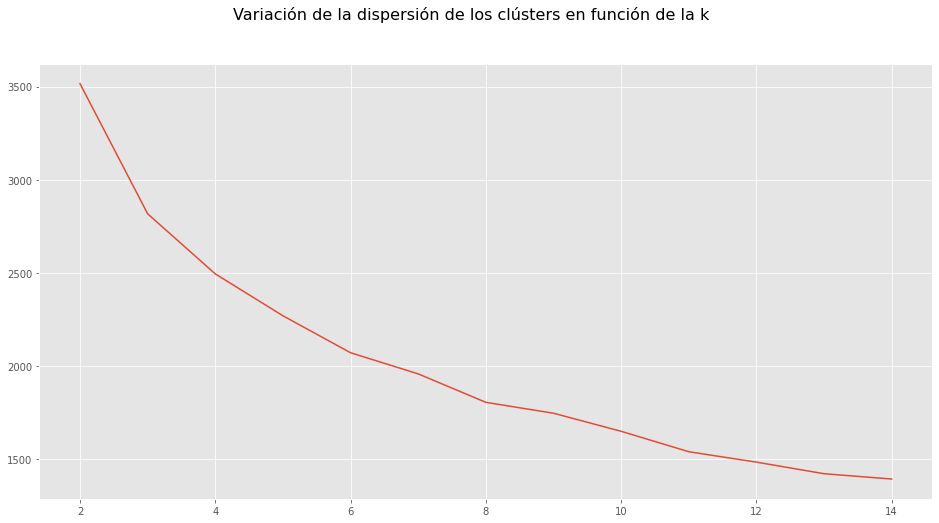

In [ ]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

La curba no acaba de hacer forma de codo. Las variables no son del todo informativas como para hacer grupos bien esparados. Usaremos 4 clusters en este caso.


In [ ]:
# Creamos de nuevo el pipeline usando 4 clusters. Esta vez si añadimos el algoritmo Kmeans al pipeline

n_clusters = 4

pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()),
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = cols_to_filter)),
    ("StandardScaler", StandardScaler()),
    ("Clustering", KMeans(n_clusters = n_clusters, random_state=9))
])

In [ ]:
df_final.shape

(226, 23)

In [ ]:
pipe.fit(df_final)

Pipeline(steps=[('Imputer', KNNImputer()),
                ('ArrayToDataFrame',
                 ArrayToDataFrame(columns=['AFOLU',
                                           'Emissions on agricultural land',
                                           'Energy', 'Energy - food systems',
                                           'Farm-gate emissions',
                                           'Fertilizers Manufacturing',
                                           'Food Household Consumption',
                                           'Food Packaging', 'Food Processing',
                                           'Food Retail', 'Food Transport',
                                           'Food Waste Disposal',
                                           'Food systems', 'IPCC Agriculture',
                                           'IPPU'...
                                              'Food Packaging',
                                              'Food Processing', 'Food Retail',
    

In [ ]:
# creamos un dataframe escalado con los pasos 1, 2 y 4
X_processed = pipe[:2].transform(df_final)
X_scaled = pipe["StandardScaler"].transform(X_processed)

X_scaled.shape

(226, 23)

In [ ]:
# hacemos el predict, en este caso tendremos para cada pais su centroide/clúster.

labels = pipe["Clustering"].predict(X_scaled)

(array([28., 86., 94., 18.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <a list of 4 Patch objects>)

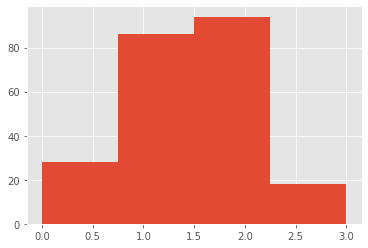

In [ ]:
# cuantos hay de cada grupo

plt.hist(labels,bins=n_clusters)

In [ ]:
# le asignamos al DataFrame procesado los centroides. (antes del escalado de variable)
# SI LO HACEMOS AL ESCALADO LOS NÚMEROS PERDERAN SU SIGNIFICADO ESCALA Y SERÁN MÁS DÍFICILES DE INTERPRETAR.
X_processed["cluster"] = labels

In [ ]:
X_processed.shape

(226, 24)

In [ ]:
X_processed.columns

Index(['AFOLU', 'Emissions on agricultural land', 'Energy',
       'Energy - food systems', 'Farm-gate emissions',
       'Fertilizers Manufacturing', 'Food Household Consumption',
       'Food Packaging', 'Food Processing', 'Food Retail', 'Food Transport',
       'Food Waste Disposal', 'Food systems', 'IPCC Agriculture', 'IPPU',
       'LULUCF', 'LULUCF - food systems', 'Land Use change',
       'On-farm electricity use', 'Other', 'Pre- and post- production',
       'Waste', 'Waste - food systems', 'cluster'],
      dtype='object')

AFOLU
Emissions on agricultural land
Energy
Energy - food systems
Farm-gate emissions
Fertilizers Manufacturing
Food Household Consumption
Food Packaging
Food Processing
Food Retail
Food Transport
Food Waste Disposal
Food systems
IPCC Agriculture
IPPU
LULUCF
LULUCF - food systems
Land Use change
On-farm electricity use
Other
Pre- and post- production
Waste
Waste - food systems


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_

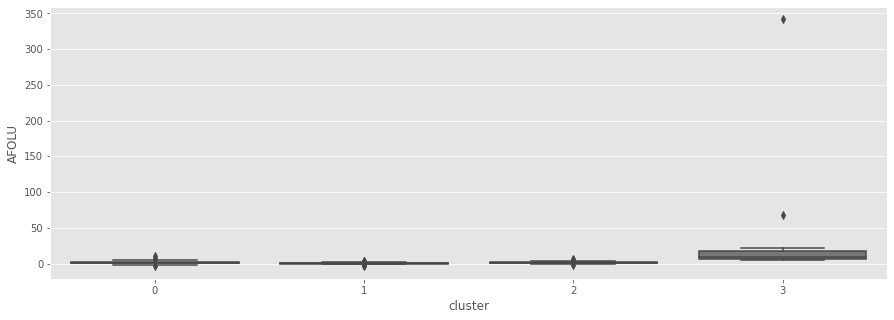

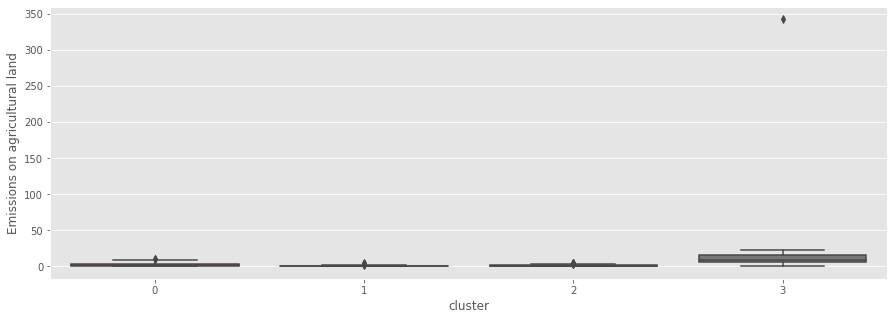

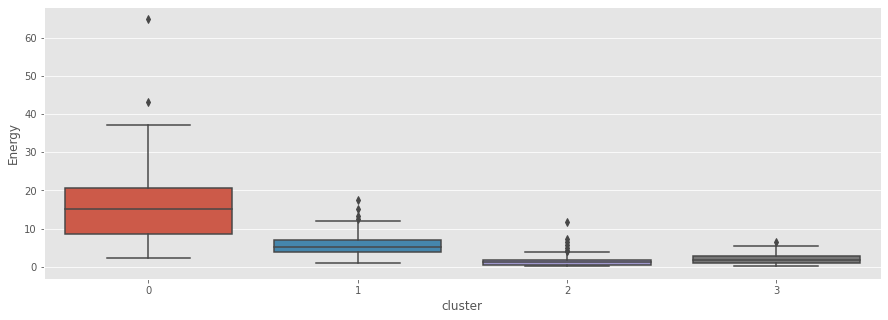

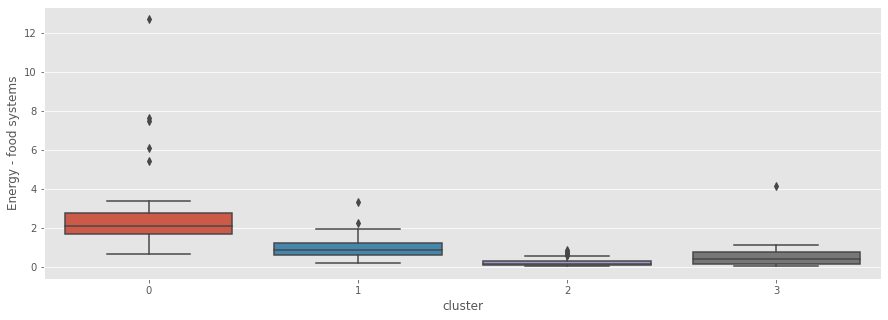

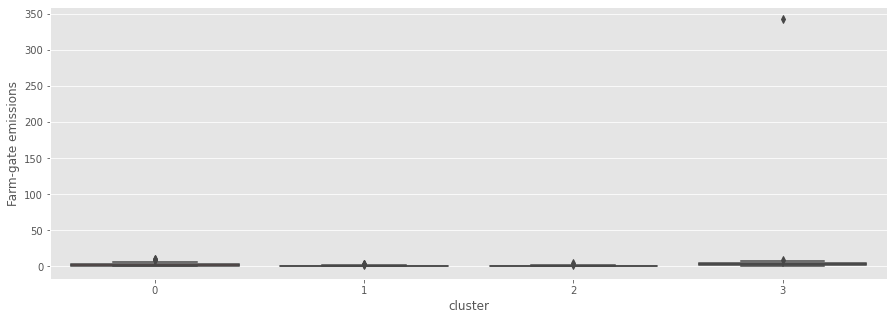

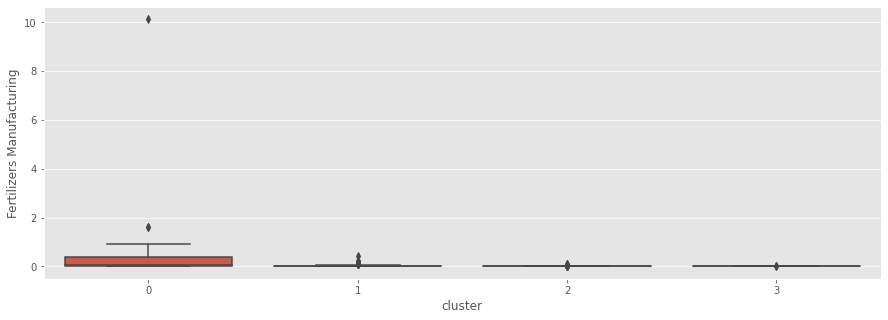

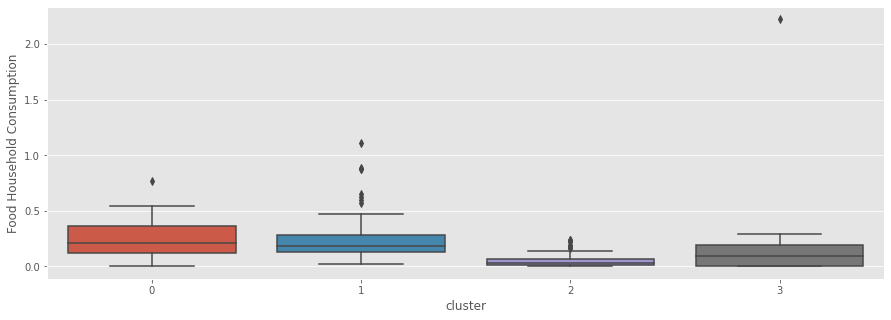

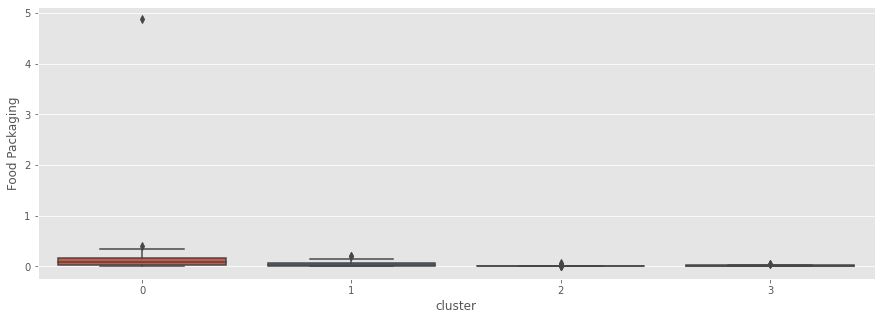

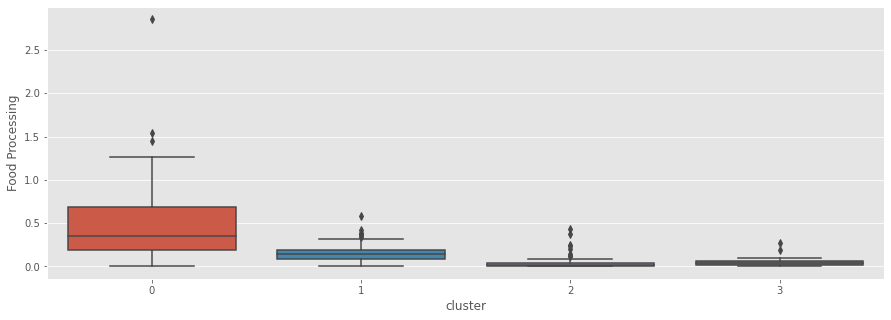

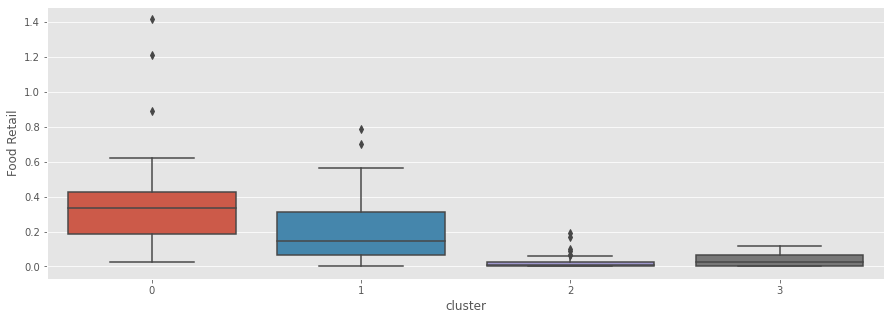

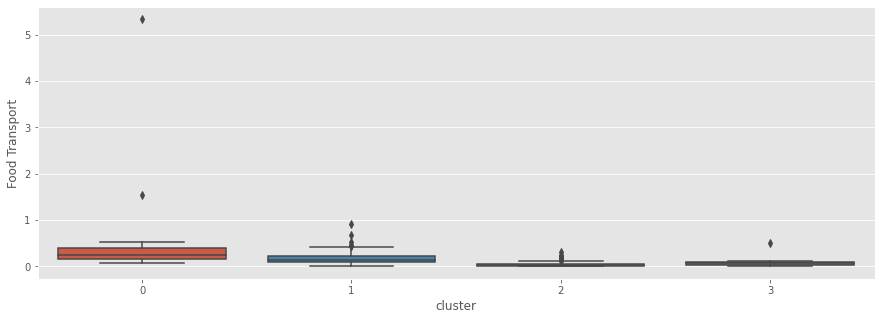

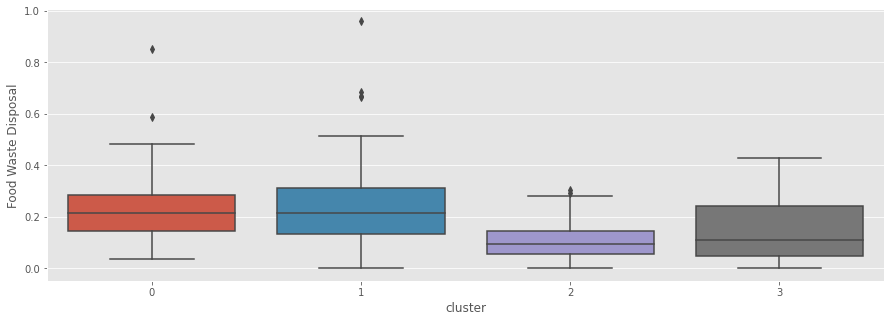

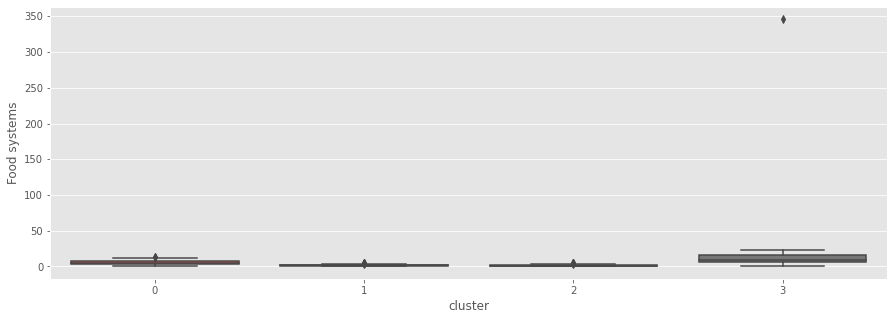

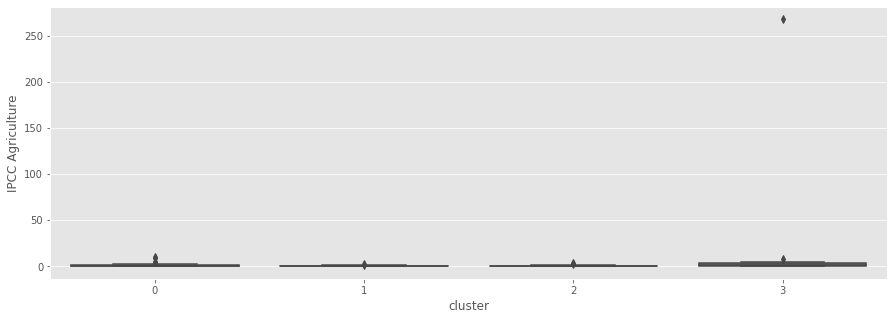

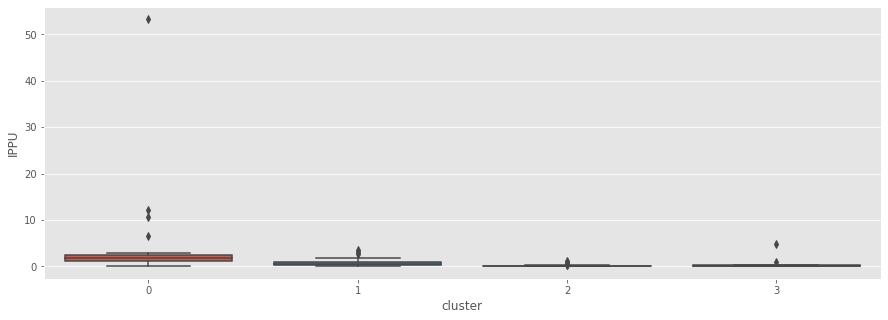

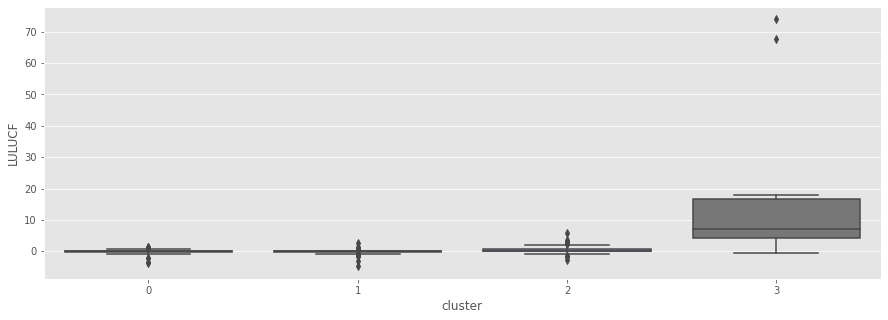

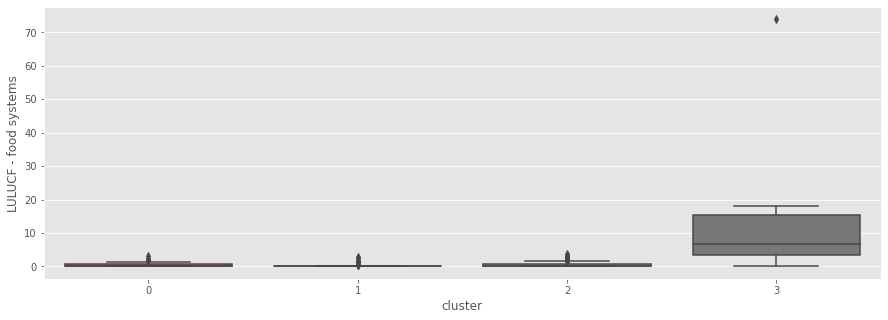

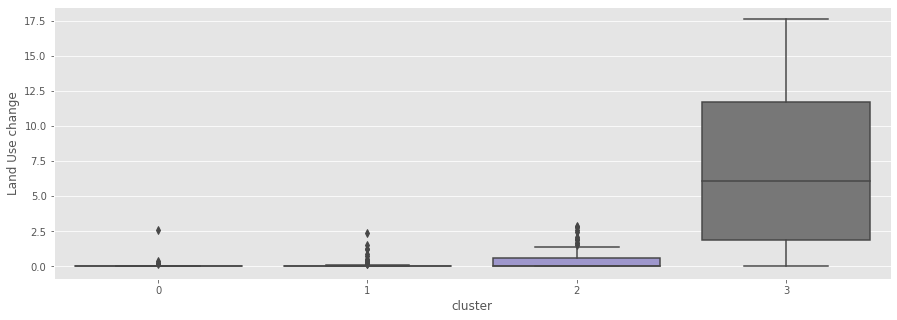

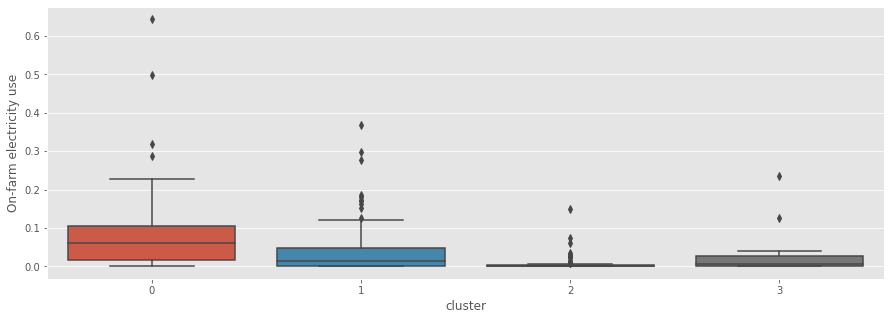

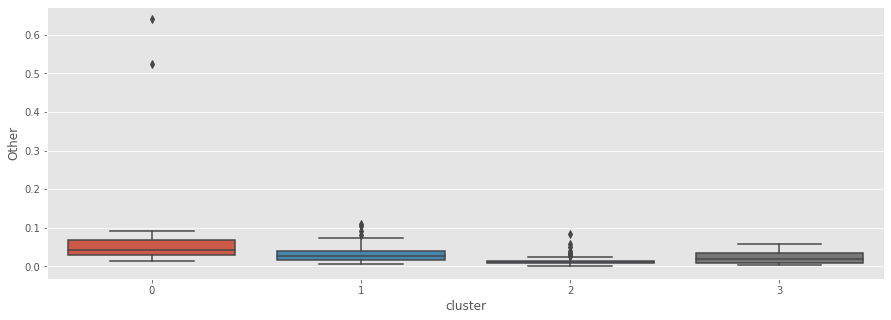

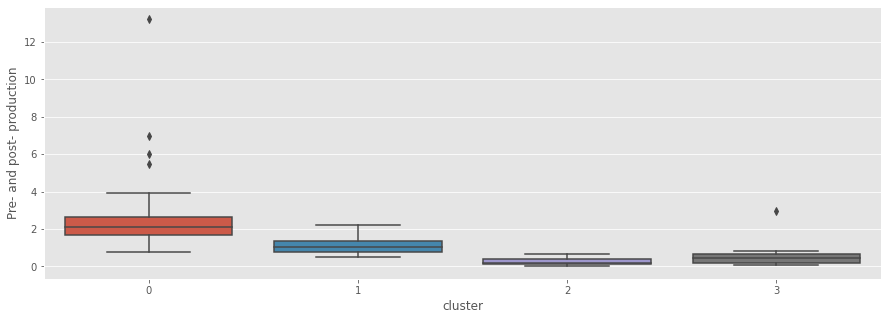

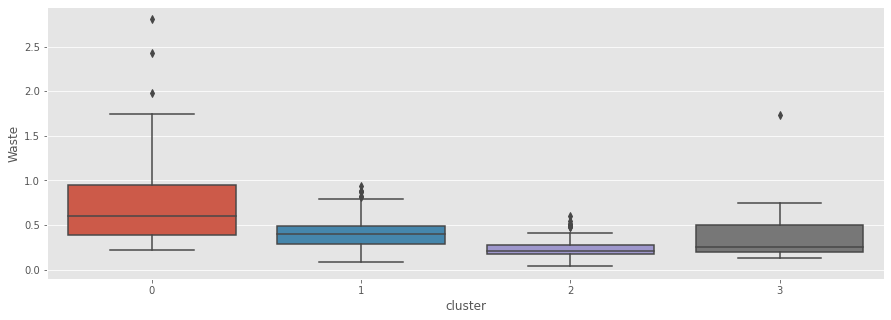

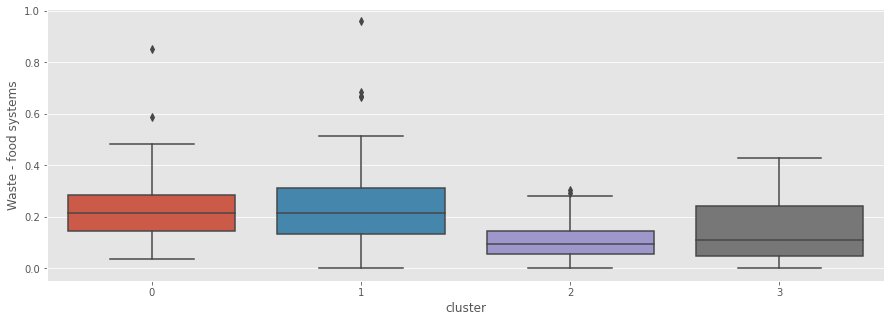

In [ ]:
# visualizamos de una forma rápida en qué variables los clusters se diferencian de los demás.

for col in X_processed.columns[:-1]:
  print(col)
  plt.figure(figsize=(15,5))
  sns.boxplot(
    data = X_processed, 
    x = 'cluster',
    y = col
)



A la vista de los gráficos anteriores, visualizaremos nuestros grupos en base a variables que vemos en los gráficos que son discriminantes.

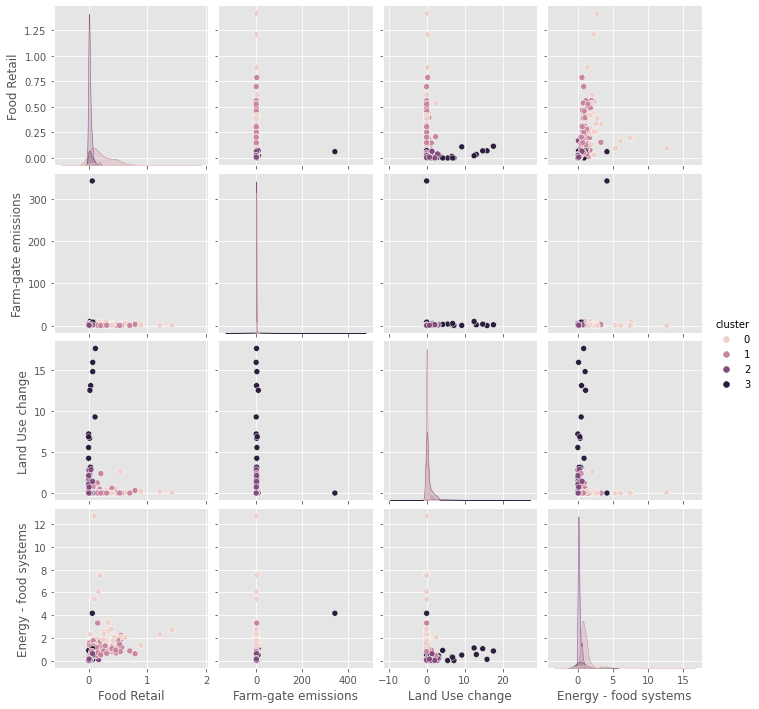

In [ ]:
# visualizamos nuestros grupos en base a las variables del modelo RFM, para ver rápiamente diferencias entre clusters de una forma más compacta que la anterior.
selected_columns = ['Food Retail', 'Farm-gate emissions', 'Land Use change','Energy - food systems']

sns.pairplot(X_processed, vars = selected_columns, hue = 'cluster');

Hay un grupo de países que emite muchos más gases por “Land Use Change” que el resto, que son gases debidos básicamente a deforestación para cultivo. (Gráficas en la tercera fila - cluster 3 separado del resto)
Las emisiones de la venta al por menor permite separar los clusters 0 y 1 del resto,(Gráficos fila superior) y que el cluster 0 tiene una emisión debida a la energía en los sistemas agroalimentarios superior al resto.(gràficos de abajo)


### Caracterización.
Los intentamos caracterizar usando PIB per capita y por su pertenencia o no al Anexo I de Kioto. 
Se podrían haber caracterizado también por población o emisiones totales entre otras muchas posibilidades. 

#### PIB per Cápita

In [ ]:
check_point = X_processed.copy(deep=True)

In [ ]:
X_processed = X_processed.reset_index()

In [ ]:
print(X_processed.shape)

(226, 25)


In [ ]:
# Hacemos un merge del PIB per cápita del año 2019, que el con el que estamos trabajando desde el inicio.

AÑO_CLUSTER = 2019
df_PIB_Dol_Cap_2019 = df_PIB_Dol_Cap[df_PIB_Dol_Cap["Year"] == AÑO_CLUSTER][["Area", "Value"]]

print(X_processed.shape)
X_processed = pd.merge(X_processed, df_PIB_Dol_Cap_2019, left_on="index", right_on= "Area", how="left")
print(X_processed.shape)

(226, 25)
(226, 27)


In [ ]:
# Comprobamos que nos ha añadido la información del PIB per Cápita a la derecha del dataset.

X_processed.head()

,index,AFOLU,Emissions on agricultural land,Energy,Energy - food systems,Farm-gate emissions,Fertilizers Manufacturing,Food Household Consumption,Food Packaging,Food Processing,...,LULUCF - food systems,Land Use change,On-farm electricity use,Other,Pre- and post- production,Waste,Waste - food systems,cluster,Area,Value
0,Afghanistan,0.433665,0.432978,0.278978,0.027891,0.432978,0.000611,0.012786,0.000321,0.002079,...,0.000000,0.000000,0.001155,0.002341,0.116606,0.146425,0.092093,2,Afghanistan,469.919090
1,Albania,0.936675,1.181635,1.719789,0.339630,1.181635,0.000000,0.062884,0.006693,0.027720,...,0.039617,0.000000,0.002045,0.011498,0.488936,0.189165,0.238039,2,Albania,5303.197823
2,Algeria,0.299427,0.317502,5.352839,0.688193,0.302685,0.081096,0.386078,0.027864,0.057468,...,0.014817,0.014817,0.016862,0.014280,0.904992,0.478741,0.219163,1,Algeria,3975.510381
3,American Samoa,-0.743887,0.166830,1.635057,0.113675,0.000036,0.000000,0.059989,0.001442,0.031001,...,0.166794,0.166794,0.000008,0.022950,0.149443,0.204912,0.035768,2,NaN,NaN
4,Angola,2.670236,2.666654,1.912714,0.095980,1.162186,0.000000,0.031261,0.013148,0.004474,...,1.517771,1.504468,0.000000,0.012740,0.173488,0.168654,0.082615,2,Angola,2670.850732


In [ ]:
# Le cambianos el nombre a la columa que se ha añadido con el Pib

X_processed = X_processed.rename(columns={"Value": "PIB_Cap"})


In [ ]:
X_processed.isnull().sum()

index                              0
AFOLU                              0
Emissions on agricultural land     0
Energy                             0
Energy - food systems              0
Farm-gate emissions                0
Fertilizers Manufacturing          0
Food Household Consumption         0
Food Packaging                     0
Food Processing                    0
Food Retail                        0
Food Transport                     0
Food Waste Disposal                0
Food systems                       0
IPCC Agriculture                   0
IPPU                               0
LULUCF                             0
LULUCF - food systems              0
Land Use change                    0
On-farm electricity use            0
Other                              0
Pre- and post- production          0
Waste                              0
Waste - food systems               0
cluster                            0
Area                              21
PIB_Cap                           21
d

Algunos países de nuestro dataset no estaban en la tabla con la información del PIB. Los quitaremos de la caracterización.

In [ ]:
X_processed.dropna(inplace=True)

In [ ]:
X_processed.shape

(205, 27)

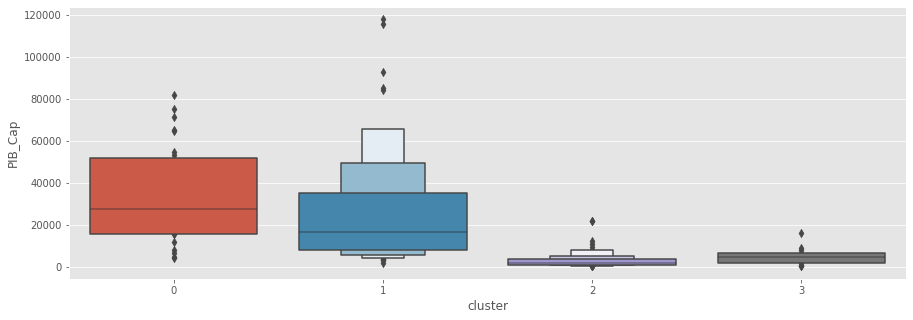

In [ ]:
plt.figure(figsize=(15,5))
sns.boxenplot(
    data = X_processed, 
    x = 'cluster',
    y = "PIB_Cap"
)


Clusters 0 y 1, que son los que más PIB per cápita tienen, eran también los que desprenden más CO2 en Food Retail i algo más también en energia en sus sistema agroalimentarios.
Los países que más deforestan, cluster 3, son de PIB bajo. Finalemte el cluster 2, que es el más numeroso, vemos que ha agrupado los países con el PIB menor. 


In [ ]:
# Exportamos la clusterización para poder ser usada en la parte de Time Series

X_processed[["index","cluster"]].rename(columns={"index": "Area"}).to_csv("Cluster_Paises_Sector_4_clusters.csv")

#### Anexo I Kioto
Vemos si cada cluster se puede caracterizar con la informacion de paises den el Anexo I de Kyoto

In [ ]:
X_processed.head(1)

,index,AFOLU,Emissions on agricultural land,Energy,Energy - food systems,Farm-gate emissions,Fertilizers Manufacturing,Food Household Consumption,Food Packaging,Food Processing,...,LULUCF - food systems,Land Use change,On-farm electricity use,Other,Pre- and post- production,Waste,Waste - food systems,cluster,Area,PIB_Cap
0,Afghanistan,0.433665,0.432978,0.278978,0.027891,0.432978,0.000611,0.012786,0.000321,0.002079,...,0.0,0.0,0.001155,0.002341,0.116606,0.146425,0.092093,2,Afghanistan,469.91909


In [ ]:
# Como en el caso para el PIB, creamos un primer dataset con el país y la variable "Annex I countries"

a = df_emis_sec[["Area Code", "Area"]].drop_duplicates()
print(a.shape)
a = pd.merge(a,df_paises_Kyoto, on="Area Code", how="left")
print(a.shape)

(275, 2)
(275, 4)


In [ ]:
df_paises_Kyoto.head()

Country Group,Area Code,Country,Annex I countries
0,1,Armenia,0.0
1,2,Afghanistan,0.0
2,3,Albania,0.0
3,4,Algeria,0.0
4,5,American Samoa,1.0


In [ ]:
# hacemos merge de nuestro dataset principial con la información del Anexo I

print(X_processed.shape)
X_processed = pd.merge(X_processed, a, left_on="index", right_on= "Area", how="left")
print(X_processed.shape)

(205, 27)
(205, 31)


In [ ]:
# Comprobamos que se han añadido las columnas. Vemos cuales de ellas tienen información que ya tenemos en otras columnas 

X_processed.head(1)

,index,AFOLU,Emissions on agricultural land,Energy,Energy - food systems,Farm-gate emissions,Fertilizers Manufacturing,Food Household Consumption,Food Packaging,Food Processing,...,Pre- and post- production,Waste,Waste - food systems,cluster,Area_x,PIB_Cap,Area Code,Area_y,Country,Annex I countries
0,Afghanistan,0.433665,0.432978,0.278978,0.027891,0.432978,0.000611,0.012786,0.000321,0.002079,...,0.116606,0.146425,0.092093,2,Afghanistan,469.91909,2,Afghanistan,Afghanistan,0.0


In [ ]:
# Eliminamos las columnas con info repetida

X_processed.drop(["Area_y","Country"], axis="columns", inplace = True)
X_processed.head(1)

,index,AFOLU,Emissions on agricultural land,Energy,Energy - food systems,Farm-gate emissions,Fertilizers Manufacturing,Food Household Consumption,Food Packaging,Food Processing,...,On-farm electricity use,Other,Pre- and post- production,Waste,Waste - food systems,cluster,Area_x,PIB_Cap,Area Code,Annex I countries
0,Afghanistan,0.433665,0.432978,0.278978,0.027891,0.432978,0.000611,0.012786,0.000321,0.002079,...,0.001155,0.002341,0.116606,0.146425,0.092093,2,Afghanistan,469.91909,2,0.0


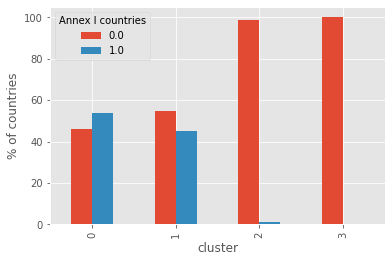

In [ ]:
plot = pd.crosstab(index=X_processed['cluster'], columns=X_processed['Annex I countries']).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar',  ylabel="% of countries")


Vemos que los paises de los clusters 2 y 3 no pertenecen en su gran mayoría al Anexo I del tratado de Kioto. Son los países con menos PIB per Cápita también. Los países en los clusters 0 y 1, que son los de PIb mayores, la proporción de países que están en Kyoto es cerca del 50% para ambos clusters. Podemos decir que esta clusterización no nos sirve para separar/predecir países pertenecientes al grupo I de Kioto en la mayoría de los casos.

##Clustering con datos de la tabla de Alimentos

### Tabla de Balance de Alimentos

En la tabla de balance de alimentos, hay información para cada alimento (gran cantidad de tipos de alimentos) y por cada país, de las toneladas producidas, importadas, exportadas, para consume interno y dentro del consumo interno, para está desgranado para una serie de usos como son alimentación humana, alimentación animal, semillas, residuos, entre otros).


In [ ]:
# Además de información para cada alimento, hay también agrupaciones de ellos. Miramos qué agrupaciones de alimentos tenemos.

df_alim[df_alim["Item Code"]>2700]["Item"].unique()

array(['Grand Total', 'Vegetal Products', 'Animal Products',
       'Cereals - Excluding Beer', 'Rice and products', 'Starchy Roots',
       'Sugar Crops', 'Sugar & Sweeteners', 'Honey', 'Pulses', 'Treenuts',
       'Oilcrops', 'Vegetable Oils', 'Vegetables',
       'Fruits - Excluding Wine', 'Stimulants', 'Spices',
       'Alcoholic Beverages', 'Meat', 'Bovine Meat', 'Mutton & Goat Meat',
       'Pigmeat', 'Poultry Meat', 'Meat, Other', 'Offals',
       'Offals, Edible', 'Animal fats', 'Butter, Ghee', 'Cream',
       'Fats, Animals, Raw', 'Eggs', 'Milk - Excluding Butter',
       'Fish, Seafood', 'Freshwater Fish', 'Miscellaneous',
       'Fish, Body Oil', 'Fish, Liver Oil', 'Demersal Fish',
       'Pelagic Fish', 'Marine Fish, Other', 'Crustaceans', 'Cephalopods',
       'Molluscs, Other', 'Aquatic Products, Other',
       'Aquatic Animals, Others', 'Aquatic Plants',
       'Meat, Aquatic Mammals'], dtype=object)

In [ ]:
# Dentro del grupo de "Vegetal Products", miramos qué información hay disponible por si fuera interesante usar estas agrupaciones

df_alim[df_alim["Item"]=='Vegetal Products']["Element"].unique()

array(['Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)'], dtype=object)

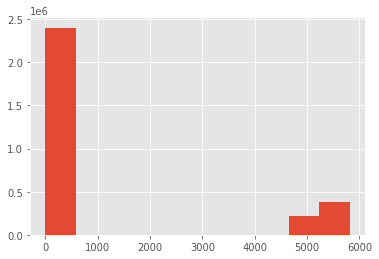

In [ ]:
# Miramos si hay agrupaciones de Paises. Si, los hay. Se trata de las Areas con códigos mayores de 4000

df_alim["Area Code"].hist()

In [ ]:
# Miramos la información que tenemos disponible para cada alimento.

df_alim.Element.unique()

array(['Total Population - Both sexes', 'Domestic supply quantity',
       'Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)', 'Production',
       'Import Quantity', 'Stock Variation', 'Export Quantity', 'Feed',
       'Seed', 'Losses', 'Processing', 'Other uses (non-food)',
       'Tourist consumption', 'Residuals', 'Food',
       'Food supply quantity (kg/capita/yr)'], dtype=object)

En esta clusterización no usaremos las variables correspondientes a información de gramos de consumo de Proteina y grasa por persona y día, como tampoco Kcal diarias o Kg de comida diarios por persona. Sólo nos centramos en información de toneladas de alimento producido, importado, exportado, de consumo interno y sus usos.

Como en el caso de la clusterización por Emisiones por sectores, usaremos sólo datos de 2019. Podría ser interesante crear clusters con datos de todos los años, y también clasificar cada país en su cluster correspondiente para diferentes años, y ver su evolución temporal de forma que podríamos ver si un país pasa de un cluster a otro con el tiempo.


In [ ]:
# Filtramos el dataset según lo comentado en los dos párrafos anteriores.

AÑO_CLUSTER = 2019
TARGET_ELEMENTS = ['Domestic supply quantity',
       'Production',
       'Import Quantity','Export Quantity', 'Feed',
       'Seed', 'Losses', 'Processing', 'Other uses (non-food)',
       'Tourist consumption', 'Residuals', 'Food']

In [ ]:
# Seleccionamos el año 2019, y los Items (tipos de alimentos) sin agrupaciones y los  Elementos escogidos. Sólo países, no agrupaciones.

df_alim_2019_select = df_alim[(df_alim['Item Code'] < 2900) & (df_alim['Item Code'] > 2501) & (df_alim["Year"]== AÑO_CLUSTER) & (df_alim['Element'].isin(TARGET_ELEMENTS)) & (df_alim["Area Code"]<1000) ]

In [ ]:
# Comprobamos que ha cogido bien los Elementos

df_alim_2019_select.Element.unique()

array(['Production', 'Import Quantity', 'Export Quantity',
       'Domestic supply quantity', 'Feed', 'Seed', 'Losses', 'Residuals',
       'Food', 'Other uses (non-food)', 'Processing',
       'Tourist consumption'], dtype=object)

In [ ]:
# Comprobamos nulos

df_alim_2019_select.isnull().sum()

Area Code       0
Area            0
Item Code       0
Item            0
Element Code    0
Element         0
Year Code       0
Year            0
Unit            0
Value           0
Flag            0
dtype: int64

In [ ]:
df_alim_2019_select.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
285,2,Afghanistan,2511,Wheat and products,5511,Production,2019,2019,1000 tonnes,4890.0,Im
295,2,Afghanistan,2511,Wheat and products,5611,Import Quantity,2019,2019,1000 tonnes,2526.0,Im
311,2,Afghanistan,2511,Wheat and products,5911,Export Quantity,2019,2019,1000 tonnes,0.0,Im
321,2,Afghanistan,2511,Wheat and products,5301,Domestic supply quantity,2019,2019,1000 tonnes,7519.0,S
331,2,Afghanistan,2511,Wheat and products,5521,Feed,2019,2019,1000 tonnes,249.0,Im


In [ ]:
# Comprobamos las unidades. Lo hacemos porque en algún dataset de la FAO se mezclan informaciones con diferentes tipos de unidades. En este caso vemos que sólo son "1000 tonnes"

df_alim_2019_select.Unit.unique()

array(['1000 tonnes'], dtype=object)

In [ ]:
# Hacemos pivot table para poner los Elementos como columnas, y para cada elemento agruparemos todos los tipos de alimentos, sumando las toneladas de todos los alimentos.

df_alim_2019_select_transp = df_alim_2019_select.pivot_table(index="Area",columns="Element",values="Value",aggfunc="sum")
df_alim_2019_select_transp.head(1)

Element,Domestic supply quantity,Export Quantity,Feed,Food,Import Quantity,Losses,Other uses (non-food),Processing,Production,Residuals,Seed,Tourist consumption
Area,,,,,,,,,,,,
Afghanistan,17996.0,1151.0,515.0,14764.0,5039.0,1375.0,37.0,955.0,13999.0,-164.0,510.0,NaN


In [ ]:
# Miramos nulos que se han podido crear con la pivot table

df_alim_2019_select_transp.isnull().sum()

Element
Domestic supply quantity      0
Export Quantity               0
Feed                          0
Food                          0
Import Quantity               0
Losses                        0
Other uses (non-food)         0
Processing                    0
Production                    0
Residuals                     0
Seed                          0
Tourist consumption         137
dtype: int64

In [ ]:
# Quitamos la variable "Tourist Consumption" porque hay más de la mitad de registros con nulos. 

df_alim_2019_select_transp.drop("Tourist consumption", axis="columns", inplace=True)

In [ ]:
# Cuantos países tenemos en esta base de datos?

df_alim_2019_select_transp.shape

(179, 11)

In [ ]:
df_clust = df_alim_2019_select_transp

Añadiremos una columna con la población de cada país para luego dividir todas las columnas por la poblacion y obtener los datos per cápita.

In [ ]:
# Anteriormente habíamos creado un DataFrame con la población de cada país. Visualizamos ese DataFrame

df_pop_both_2019_pivot.head()

Element,Total Population - Both sexes
Area,
Afghanistan,38041.754
Albania,2880.917
Algeria,43053.054
American Samoa,55.312
Andorra,77.142


In [ ]:
# En la tabla de poblacion hay más Areas que en la de Emisiones. Haremos un merge left de la tabla de emisiones, para que no falte ningun Area
print(df_clust.shape)
df_clust_pop_2019 = pd.merge(df_clust, df_pop_both_2019_pivot, on = "Area", how="left")
print(df_clust_pop_2019.shape)

(179, 11)
(179, 12)


In [ ]:
# Comprobamos si hay alguna fila que no se le ha podido asignar población.

df_clust_pop_2019[df_clust_pop_2019["Total Population - Both sexes"].isnull()]

Element,Domestic supply quantity,Export Quantity,Feed,Food,Import Quantity,Losses,Other uses (non-food),Processing,Production,Residuals,Seed,Total Population - Both sexes
Area,,,,,,,,,,,,


Todas las filas/paises tienen su población asignada.

In [ ]:
df_clust_pop_2019.columns

Index(['Domestic supply quantity', 'Export Quantity', 'Feed', 'Food',
       'Import Quantity', 'Losses', 'Other uses (non-food)', 'Processing',
       'Production', 'Residuals', 'Seed', 'Total Population - Both sexes'],
      dtype='object', name='Element')

Comprobamos la correlación entre las variables de nuestro dataset.

In [ ]:
corr = df_clust_pop_2019.corr()
corr.style.background_gradient(cmap="coolwarm")


Element,Domestic supply quantity,Export Quantity,Feed,Food,Import Quantity,Losses,Other uses (non-food),Processing,Production,Residuals,Seed,Total Population - Both sexes
Element,,,,,,,,,,,,
Domestic supply quantity,1.000000,0.526050,0.932968,0.967422,0.851855,0.964480,0.586293,0.849257,0.996865,-0.018519,0.801495,0.952371
Export Quantity,0.526050,1.000000,0.506252,0.352804,0.487149,0.547507,0.720749,0.640657,0.578508,-0.207249,0.454495,0.346740
Feed,0.932968,0.506252,1.000000,0.945204,0.921889,0.862390,0.477276,0.641331,0.918758,-0.160267,0.686801,0.856183
Food,0.967422,0.352804,0.945204,1.000000,0.875755,0.891030,0.388044,0.726206,0.947645,-0.051378,0.785301,0.967831
Import Quantity,0.851855,0.487149,0.921889,0.875755,1.000000,0.762052,0.373130,0.587197,0.827996,-0.108338,0.592857,0.793208
Losses,0.964480,0.547507,0.862390,0.891030,0.762052,1.000000,0.739160,0.844745,0.969434,0.015309,0.712344,0.876755
Other uses (non-food),0.586293,0.720749,0.477276,0.388044,0.373130,0.739160,1.000000,0.635083,0.625811,-0.037373,0.297453,0.368189
Processing,0.849257,0.640657,0.641331,0.726206,0.587197,0.844745,0.635083,1.000000,0.875782,0.135029,0.802209,0.815921
Production,0.996865,0.578508,0.918758,0.947645,0.827996,0.969434,0.625811,0.875782,1.000000,-0.024882,0.811809,0.940017


Hay bastante correlación entre varibles. A continuación dividiremos los valores por la población y veremos como se ha reducido la correlación.

Dividimos todas las columnas por la población. Lo hacemos de una forma un tanto rara... no sé hacerlo de otra forma, pero funciona. En la misma instrucción eliminamos la variable de la población.

In [ ]:
# Al igual que antes, lo hacemos de una forma un tanto extraña para evitar hacerlo con un for loop. Hemos comprobado que hace las divisiones correctamente.

df_clust_pop_2019_per_cap = (df_clust_pop_2019.T / df_clust_pop_2019["Total Population - Both sexes"]).T.drop("Total Population - Both sexes",axis="columns")


In [ ]:
corr = df_clust_pop_2019_per_cap.corr()
corr.style.background_gradient(cmap="coolwarm")

Element,Domestic supply quantity,Export Quantity,Feed,Food,Import Quantity,Losses,Other uses (non-food),Processing,Production,Residuals,Seed
Element,,,,,,,,,,,
Domestic supply quantity,1.000000,0.543841,0.581889,0.432340,0.268853,0.637794,0.431376,0.867432,0.917010,-0.305647,0.309026
Export Quantity,0.543841,1.000000,0.517308,0.377345,0.574001,0.176307,0.185541,0.407065,0.722637,-0.278687,0.361832
Feed,0.581889,0.517308,1.000000,0.606291,0.361618,0.265964,0.112347,0.255878,0.570110,-0.209003,0.556817
Food,0.432340,0.377345,0.606291,1.000000,0.382747,0.243720,0.033505,0.079116,0.381066,-0.118492,0.375948
Import Quantity,0.268853,0.574001,0.361618,0.382747,1.000000,-0.136627,0.052749,0.129844,0.143383,-0.007172,0.010904
Losses,0.637794,0.176307,0.265964,0.243720,-0.136627,1.000000,0.398919,0.505803,0.602080,-0.259900,0.143393
Other uses (non-food),0.431376,0.185541,0.112347,0.033505,0.052749,0.398919,1.000000,0.175361,0.387008,-0.039107,-0.013179
Processing,0.867432,0.407065,0.255878,0.079116,0.129844,0.505803,0.175361,1.000000,0.797527,-0.354747,0.116272
Production,0.917010,0.722637,0.570110,0.381066,0.143383,0.602080,0.387008,0.797527,1.000000,-0.366594,0.415030


Efectivamente hemos reducido mucho la correlación!! Pero continua siendo la más correlada la cantidad producida per cápita con el consumo interno per cápita y en menor grado con la exportación.

### Empezamos con la clusterizacion

In [ ]:
df_final = df_clust_pop_2019_per_cap.copy(deep = True)
columns = list(df_final.columns)
index = list(df_final.index)
cols_to_filter = list(df_final.columns)

In [ ]:
# Creamos pipeline que deja listos los datos para empezar el clustering. Elimina outliers y normaliza los valores. 


pipe = Pipeline(steps = [
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = cols_to_filter)),
    ("StandardScaler", StandardScaler())
])

In [ ]:
df_scaled_transformed_no_outliers = pipe.fit_transform(df_final)

In [ ]:
CALCULATE_ELBOW = True

if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 15):

        print(f"Fitting pipe with {k} clusters")

        clustering_model = KMeans(n_clusters = k)

        clustering_model.fit(df_scaled_transformed_no_outliers)

        sse[k] = clustering_model.inertia_

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st)/60), 2))

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters
Elbow curve took 0 minutes.


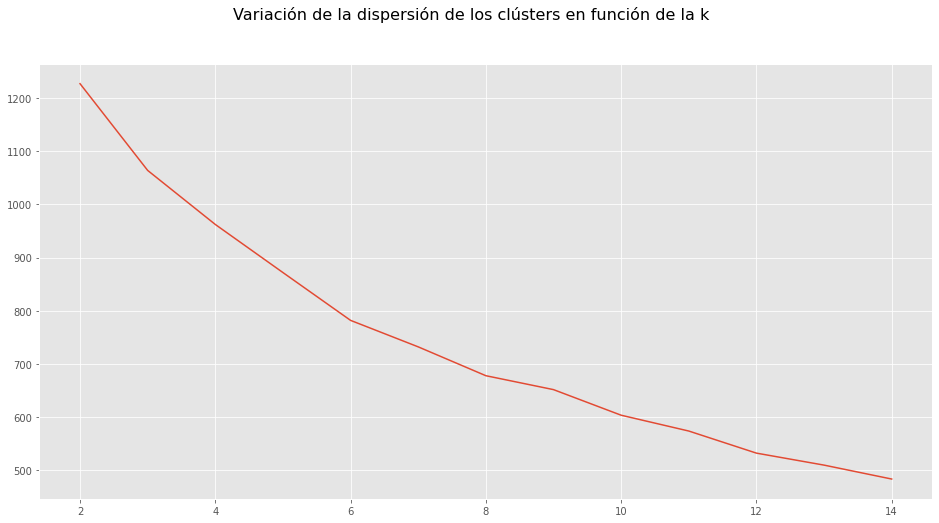

In [ ]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

La curba no acaba de hacer forma de codo. Cogeremos de nuevo un número de clusters que nos parece adecuado para poder analizar. Ni muy pequeño ni demasiado grande. Escogemos un modelo de 4 clusters.


In [ ]:
# Creamos de nuevo el pipeline usando 4 clusters para no complicar el análisis. 

n_clusters = 4

pipe = Pipeline(steps = [
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = cols_to_filter)),
    ("StandardScaler", StandardScaler()),
    ("Clustering", KMeans(n_clusters = n_clusters, random_state=9))
])

In [ ]:
df_final.shape

(179, 11)

In [ ]:
pipe.fit(df_final)

Pipeline(steps=[('ArrayToDataFrame',
                 ArrayToDataFrame(columns=['Domestic supply quantity',
                                           'Export Quantity', 'Feed', 'Food',
                                           'Import Quantity', 'Losses',
                                           'Other uses (non-food)',
                                           'Processing', 'Production',
                                           'Residuals', 'Seed'],
                                  index=['Afghanistan', 'Albania', 'Algeria',
                                         'Angola', 'Antigua and Barbuda',
                                         'Argentina', 'Armenia', 'Australia',
                                         'Austria', 'Azerbaijan', 'Bahamas',
                                         '...
                                         'Cameroon', 'Canada',
                                         'Central African Republic', 'Chad', ...])),
                ('OutlierFilter',
   

In [ ]:
# creamos un dataframe escalado con los pasos 1 y 3
X_processed = pipe[:1].transform(df_final)
X_scaled = pipe["StandardScaler"].transform(X_processed)

X_scaled.shape

(179, 11)

In [ ]:
# hacemos el predict, en este caso tendremos para cada cliente su centroide/clúster.
print(pipe["Clustering"].predict(X_scaled)[:20])
labels = pipe["Clustering"].predict(X_scaled)

[0 3 3 3 0 2 3 2 1 3 0 0 0 1 1 2 3 3 3 0]


(array([67., 39., 15., 58.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <a list of 4 Patch objects>)

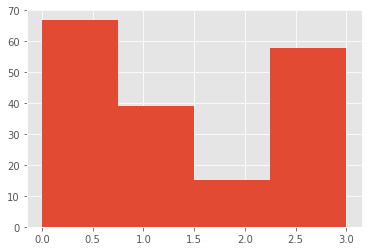

In [ ]:
# cuantos hay de cada grupo

plt.hist(labels,bins=n_clusters)

In [ ]:
# le asignamos al DataFrame procesado los centroides. (antes del escalado de variable)
# SI LO HACEMOS AL ESCALADO LOS NÚMEROS PERDERAN SU SIGNIFICADO ESCALA Y SERÁN MÁS DÍFICILES DE INTERPRETAR.
X_processed["cluster"] = labels

In [ ]:
X_processed.shape

(179, 12)

In [ ]:
X_processed.columns

Index(['Domestic supply quantity', 'Export Quantity', 'Feed', 'Food',
       'Import Quantity', 'Losses', 'Other uses (non-food)', 'Processing',
       'Production', 'Residuals', 'Seed', 'cluster'],
      dtype='object')

Domestic supply quantity
Export Quantity
Feed
Food
Import Quantity
Losses
Other uses (non-food)
Processing
Production
Residuals
Seed


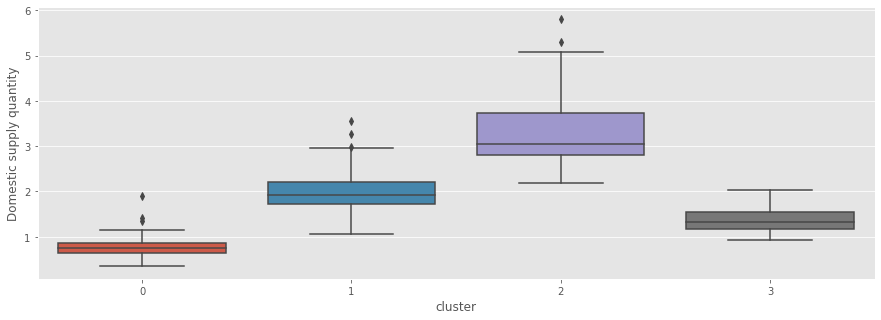

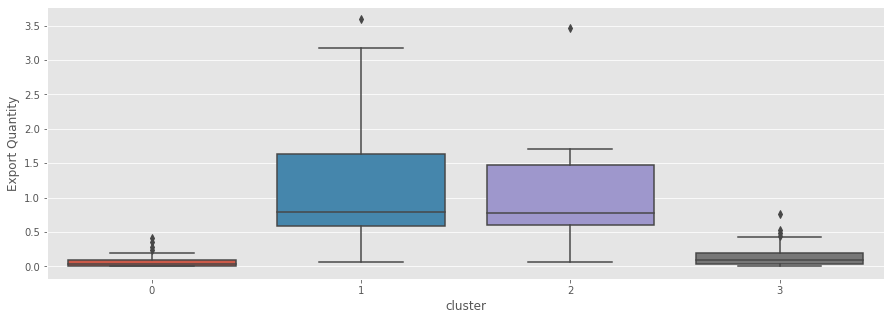

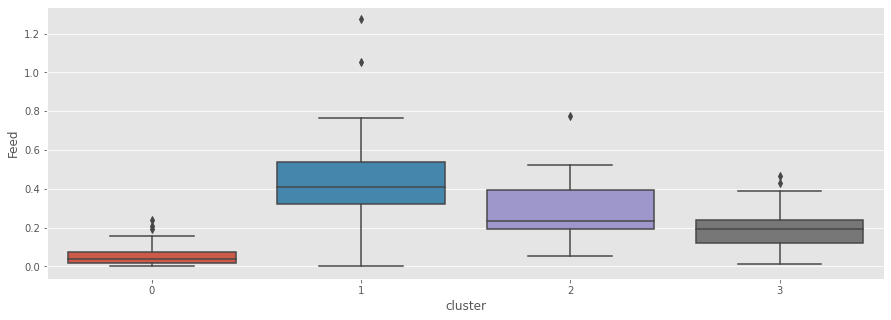

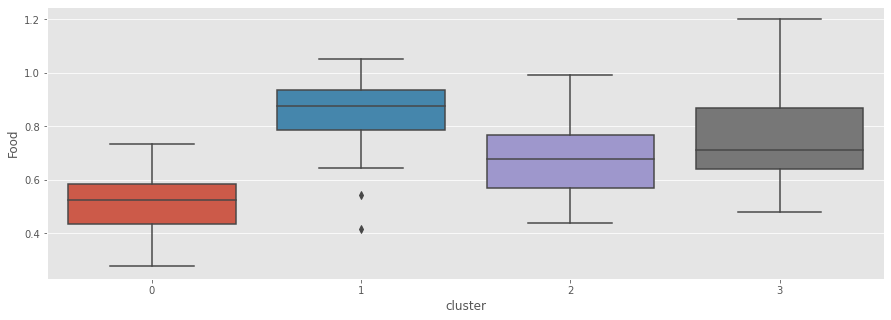

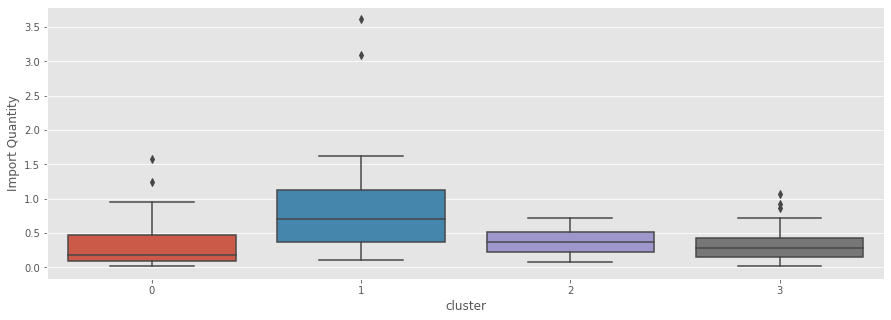

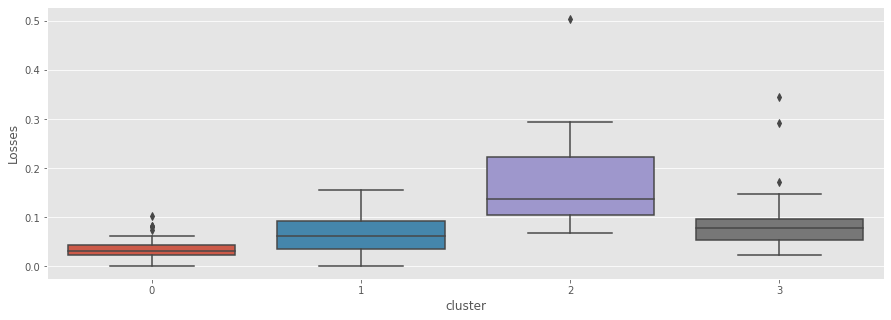

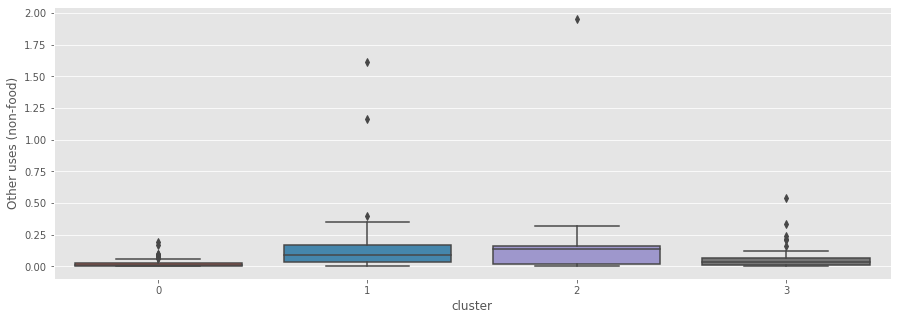

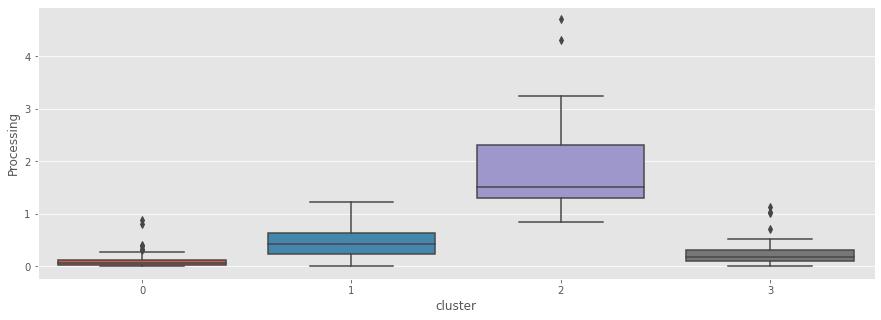

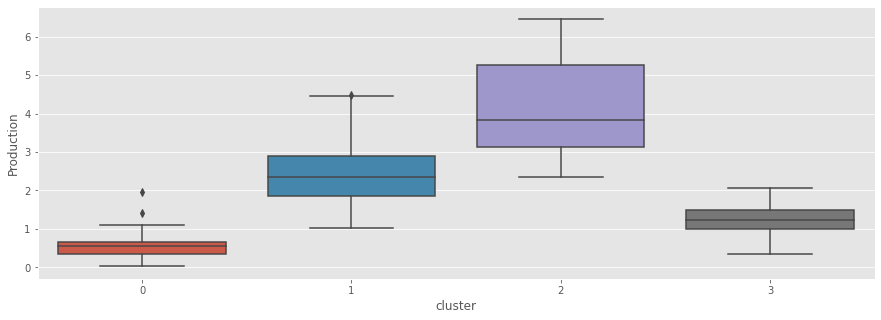

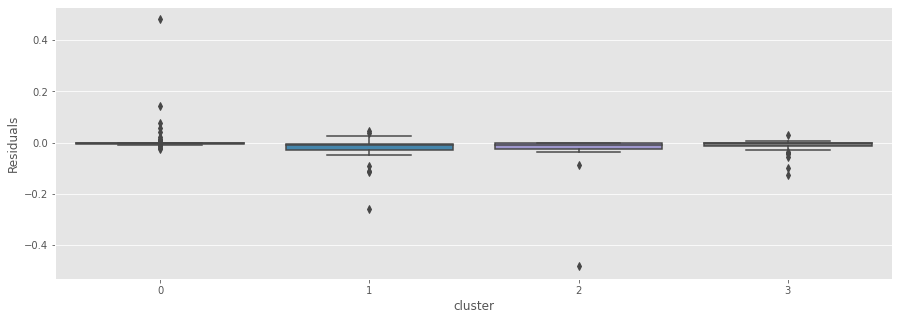

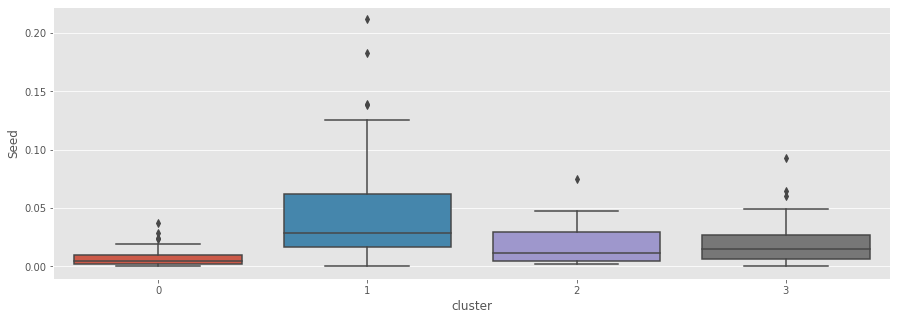

In [ ]:
# visualizamos nuestros grupos en base a las variables del modelo RFM, para ver que tal han quedado.

for col in X_processed.columns[:-1]:
  print(col)
  plt.figure(figsize=(15,5))
  sns.boxplot(
    data = X_processed, 
    x = 'cluster',
    y = col
)



Al igual que en nuestra anterior clusterización, escogemos algunas de la variables más discriminantes de los boxplots anteriores para ver las diferencias entre clusters de forma más compacta a continuación. 

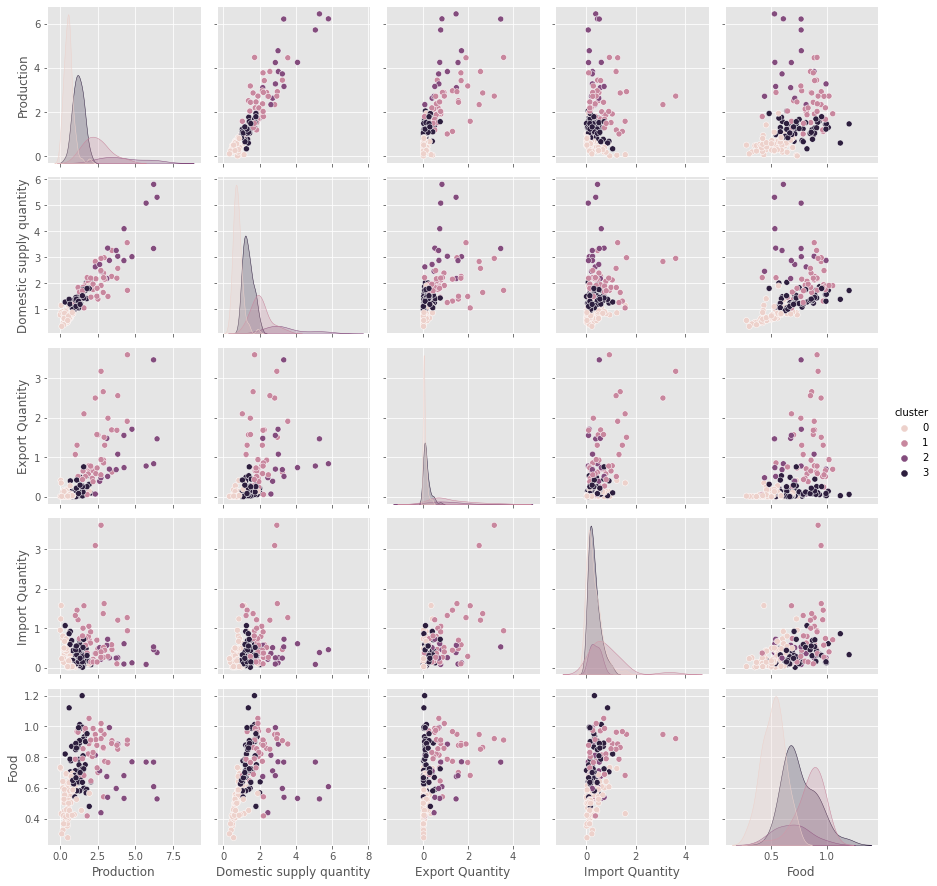

In [ ]:

selected_columns = ['Production', 'Domestic supply quantity', 'Export Quantity','Import Quantity', "Food"]

sns.pairplot(X_processed, vars = selected_columns, hue = 'cluster');

Consumo interno (Domestic supply quantity) y producción son las vars que parecen más correladas a juzgar por los gráficos de arriba, tal y como ya habíamos visto en la matriz de correlación. Además, parece que la variable de consumo interno tiene mucho peso en la clusterización. Lo podemos ver en cualquiera de los gráficos de la segunda columna. Cada cluster está relacionado con un intervalo de consumo interno per cápita.

Vemos también que la clusterización ha separado los países que exportan poco (cluster 0 y 3) de los que si exportan (clusters 1 y 2). También en el consumo de comida (variable Food) los clusters separan de forma bastante clara los países que consumen más (1 y 3) de los que consumen menos (0 y 2).

Nos encontramos pues, con un cluster que comsume poco y exporta poco, otro que consume mucho y exporta mucho, un tercer cluster que consume mucho y exporta poco y finalmente uno que consume poco y exporta mucho. Con este par de variables nos quedan los clusters separados, al igual que nos pasaba con la variable "Consumo interno".

### Caracterización.

#### PIB per Cápita

In [ ]:
# Hacemos un merge del PIB per cápita del año 2019.

AÑO_CLUSTER = 2019
df_PIB_Dol_Cap_2019 = df_PIB_Dol_Cap[df_PIB_Dol_Cap["Year"] == AÑO_CLUSTER][["Area", "Value"]]

print(X_processed.shape)
X_processed = pd.merge(X_processed.reset_index(), df_PIB_Dol_Cap_2019, left_on="index", right_on= "Area", how="left")
print(X_processed.shape)

(179, 12)
(179, 15)


In [ ]:
X_processed.head(1)

,index,Domestic supply quantity,Export Quantity,Feed,Food,Import Quantity,Losses,Other uses (non-food),Processing,Production,Residuals,Seed,cluster,Area,Value
0,Afghanistan,0.473059,0.030256,0.013538,0.3881,0.13246,0.036144,0.000973,0.025104,0.36799,-0.004311,0.013406,0,Afghanistan,469.91909


In [ ]:
# Renombramos la columnas que se han añadido.
X_processed = X_processed.rename(columns={"Value": "PIB_Cap"})
X_processed.head()

,index,Domestic supply quantity,Export Quantity,Feed,Food,Import Quantity,Losses,Other uses (non-food),Processing,Production,Residuals,Seed,cluster,Area,PIB_Cap
0,Afghanistan,0.473059,0.030256,0.013538,0.388100,0.132460,0.036144,0.000973,0.025104,0.367990,-0.004311,0.013406,0,Afghanistan,469.919090
1,Albania,1.720310,0.061099,0.251368,1.199930,0.333713,0.122878,0.046513,0.081224,1.473385,-0.000694,0.017703,3,Albania,5303.197823
2,Algeria,1.083749,0.016242,0.128028,0.776383,0.387711,0.094767,0.048778,0.025759,0.723615,-0.000070,0.010173,3,Algeria,3975.510381
3,Angola,0.916322,0.003363,0.070775,0.624465,0.116097,0.103188,0.005247,0.103251,0.790642,0.000000,0.009238,3,Angola,2670.850732
4,Antigua and Barbuda,0.910336,0.000927,0.000206,0.600198,0.734364,0.000000,0.021623,0.000000,0.197492,0.020594,0.000000,0,Antigua and Barbuda,17112.821135


In [ ]:
# Comprobamos si ha quedado algún paíse sien el PIB
X_processed.isnull().sum()

index                       0
Domestic supply quantity    0
Export Quantity             0
Feed                        0
Food                        0
Import Quantity             0
Losses                      0
Other uses (non-food)       0
Processing                  0
Production                  0
Residuals                   0
Seed                        0
cluster                     0
Area                        1
PIB_Cap                     1
dtype: int64

In [ ]:
# Visualizamos el pais sin PIB
X_processed[X_processed.Area.isnull()]

,index,Domestic supply quantity,Export Quantity,Feed,Food,Import Quantity,Losses,Other uses (non-food),Processing,Production,Residuals,Seed,cluster,Area,PIB_Cap
34,"China, Taiwan Province of",1.061921,0.096448,0.239807,0.610771,0.613199,0.0265,0.029168,0.167074,0.553975,-0.013586,0.002313,0,NaN,NaN


In [ ]:
# Borramos el registro

X_processed.dropna(inplace=True)

In [ ]:
X_processed.shape

(178, 15)

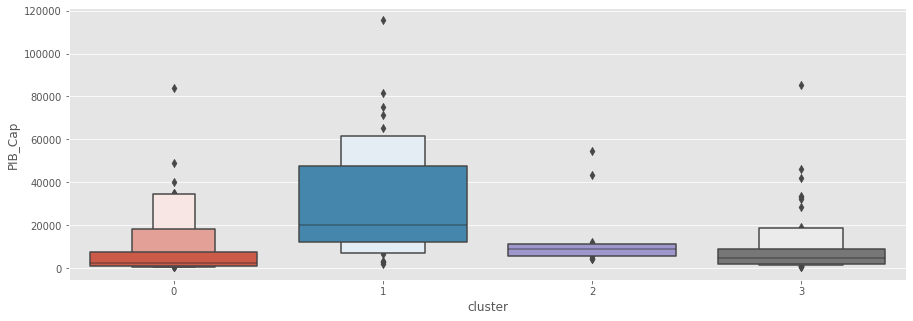

In [ ]:
# Visualizamos el PIB per cápita de los diferentes clusters

plt.figure(figsize=(15,5))
sns.boxenplot(
    data = X_processed, 
    x = 'cluster',
    y = "PIB_Cap"
)


Vemos en el gráfico anterior que el cluster 1 ha agrupado los países con mayor PIB (hay unos 40 países, algo menos del 25%) con alguna excepción. Este cluster era el que más consumía y más exportaba.
Los demás clusters,expecialmente el 0 y el 3, agrupan los países con menos PIB per cápita.

In [ ]:
# Exportamos la clusterización para poder ser usada en la parte de Time Series

X_processed[["index","cluster"]].rename(columns={"index": "Area"}).to_csv("Cluster_Paises_Produccion_Imp_Exp_4_clusters.csv")

In [ ]:
X_processed.head(1)

,index,Domestic supply quantity,Export Quantity,Feed,Food,Import Quantity,Losses,Other uses (non-food),Processing,Production,Residuals,Seed,cluster,Area,PIB_Cap
0,Afghanistan,0.473059,0.030256,0.013538,0.3881,0.13246,0.036144,0.000973,0.025104,0.36799,-0.004311,0.013406,0,Afghanistan,469.91909


#### Anexo I Kioto
Vemos si cada cluster se puede caracterizar con la informacion de paises den el Anexo I de Kyoto

In [ ]:
aux_kioto = df_alim[["Area Code", "Area"]].drop_duplicates()
print(aux_kioto.shape)
aux_kioto = pd.merge(aux_kioto,df_paises_Kyoto, on="Area Code", how="left")
print(aux_kioto.shape)

(215, 2)
(215, 4)


In [ ]:
df_paises_Kyoto.head()

Country Group,Area Code,Country,Annex I countries
0,1,Armenia,0.0
1,2,Afghanistan,0.0
2,3,Albania,0.0
3,4,Algeria,0.0
4,5,American Samoa,1.0


In [ ]:
a.head(5)

,Area Code,Area,Country,Annex I countries
0,2,Afghanistan,Afghanistan,0.0
1,3,Albania,Albania,0.0
2,4,Algeria,Algeria,0.0
3,5,American Samoa,American Samoa,1.0
4,7,Angola,Angola,0.0


In [ ]:
# hacemos merge con la información del Anexo I

print(X_processed.shape)
X_processed = pd.merge(X_processed, a, left_on="index", right_on= "Area", how="left")
print(X_processed.shape)

(178, 15)
(178, 19)


In [ ]:
X_processed.head(1)

,index,Domestic supply quantity,Export Quantity,Feed,Food,Import Quantity,Losses,Other uses (non-food),Processing,Production,Residuals,Seed,cluster,Area_x,PIB_Cap,Area Code,Area_y,Country,Annex I countries
0,Afghanistan,0.473059,0.030256,0.013538,0.3881,0.13246,0.036144,0.000973,0.025104,0.36799,-0.004311,0.013406,0,Afghanistan,469.91909,2,Afghanistan,Afghanistan,0.0


In [ ]:
X_processed.drop(["Area_y","Country"], axis="columns", inplace = True)
X_processed.head(1)

,index,Domestic supply quantity,Export Quantity,Feed,Food,Import Quantity,Losses,Other uses (non-food),Processing,Production,Residuals,Seed,cluster,Area_x,PIB_Cap,Area Code,Annex I countries
0,Afghanistan,0.473059,0.030256,0.013538,0.3881,0.13246,0.036144,0.000973,0.025104,0.36799,-0.004311,0.013406,0,Afghanistan,469.91909,2,0.0


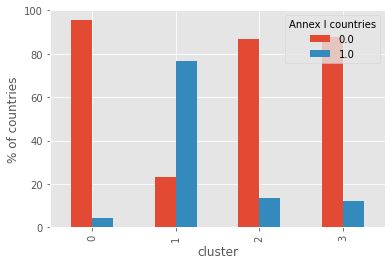

In [ ]:
plot = pd.crosstab(index=X_processed['cluster'], columns=X_processed['Annex I countries']).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar', ylabel="% of countries")


En esta caracterización es interesante remarcar como cada cluster tiene una relación fuerte con el hecho de pertenecer o no en el Anexo I de Kioto. Y eso que no se han tenido en cuenta emisiones propiamente.

## Clustering de paises con datos de emisiones en los procesos agrícolas y ganaderos.

### Tabla de Emisiones Totales

In [ ]:
# Vemos la estructura de columnas de la tabla. Es igual a las demás tablas de la FAO.
df_emis_tot.columns

Index(['Area Code', 'Area', 'Item Code', 'Item', 'Element Code', 'Element',
       'Year Code', 'Year', 'Source Code', 'Source', 'Unit', 'Value', 'Flag',
       'Note'],
      dtype='object')

In [ ]:
df_emis_tot.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Source Code,Source,Unit,Value,Flag,Note
0,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1961,1961,3050,FAO TIER 1,kilotonnes,240.6831,Fc,NaN


In [ ]:
# Visualizamos los nulos

df_emis_tot.isnull().sum()

Area Code             0
Area                  0
Item Code             0
Item                  0
Element Code          0
Element               0
Year Code             0
Year                  0
Source Code           0
Source                0
Unit                  0
Value                 0
Flag              57525
Note            1247935
dtype: int64

No encontramos nulos en los valores de emisiones (columna "Value")

In [ ]:
# Vemos qué información hay en la tabla. Empezamos por visualizar la columna "Item"
df_emis_tot["Item"].unique()

array(['Enteric Fermentation', 'Manure Management', 'Rice Cultivation',
       'Synthetic Fertilizers', 'Manure applied to Soils',
       'Manure left on Pasture', 'Crop Residues',
       'Burning - Crop residues', 'Net Forest conversion', 'Forestland',
       'Savanna fires', 'Fires in humid tropical forests', 'Forest fires',
       'Fires in organic soils', 'On-farm energy use', 'IPCC Agriculture',
       'Agricultural Soils', 'LULUCF', 'AFOLU',
       'Emissions on agricultural land', 'Farm-gate emissions',
       'Land Use change', 'Drained organic soils',
       'Drained organic soils (CO2)', 'Drained organic soils (N2O)'],
      dtype=object)

Vemos que la columna 'Item' contiene información sobre el tipo de proceso.

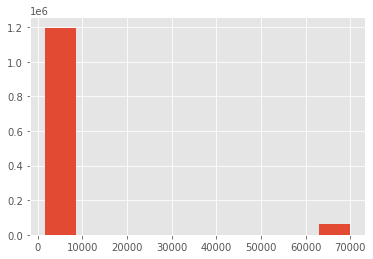

In [ ]:
# Vemos si hay alguna agrupación. En las tablas de la FAO, las agrupaciones tienen códigos separados de los
# códigos de las variables que tienen información no agrupada. Esta separación puede también responder a distintos tipos de información.
df_emis_tot["Item Code"].hist()

Vemos unas variables con códigos muy separados del resto. A continuación descubrimos qué procesos son:

In [ ]:
# Miramos qué agrupaciones de alimentos tenemos

df_emis_tot[df_emis_tot["Item Code"]>10000]["Item"].unique()

array(['Fires in humid tropical forests', 'Drained organic soils (CO2)',
       'Drained organic soils (N2O)'], dtype=object)

Sólo hay emisiones relacionadas con el cambio de uso de la tierra. Vemos las demás.

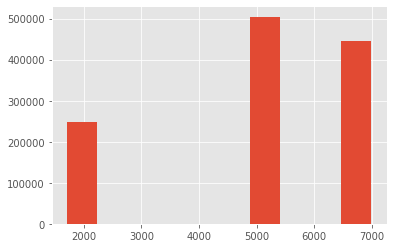

In [ ]:
df_emis_tot[df_emis_tot["Item Code"]<10000]["Item Code"].hist()

Encontramos lo que parecen nuevas agrupaciones. Analizamos qué procesos hay en cad uno de los grupos.

In [ ]:
df_emis_tot[df_emis_tot["Item Code"]<3000 ]["Item"].unique()

array(['IPCC Agriculture', 'Agricultural Soils', 'LULUCF'], dtype=object)

In [ ]:
df_emis_tot[(df_emis_tot["Item Code"]>3000) & (df_emis_tot["Item Code"]<6000)]["Item"].unique()

array(['Enteric Fermentation', 'Manure Management', 'Rice Cultivation',
       'Synthetic Fertilizers', 'Manure applied to Soils',
       'Manure left on Pasture', 'Crop Residues',
       'Burning - Crop residues'], dtype=object)

In [ ]:
df_emis_tot[(df_emis_tot["Item Code"]>6000) & (df_emis_tot["Item Code"]<8000)]["Item"].unique()

array(['Net Forest conversion', 'Forestland', 'Savanna fires',
       'Forest fires', 'Fires in organic soils', 'On-farm energy use',
       'AFOLU', 'Emissions on agricultural land', 'Farm-gate emissions',
       'Land Use change', 'Drained organic soils'], dtype=object)

Decidimos escoger para nuestro clustering los procesos que más gases de efecto invernadero generan, segun la parte de EDA de nuestro proyecto.

In [ ]:
# Escogemos los Items que más gas generan

ITEMS_TO_USE = ['Enteric Fermentation', 'Manure Management', 'Rice Cultivation',
       'Synthetic Fertilizers', 'Manure applied to Soils',
       'Manure left on Pasture', 'Crop Residues',
       'Burning - Crop residues','Drained organic soils', 'On-farm energy use']

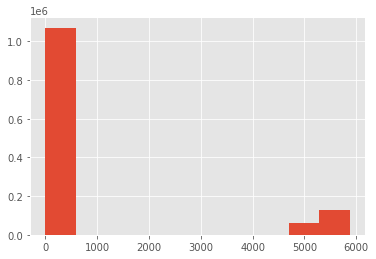

In [ ]:
# Vemos si hay agrupaciones en las areas.

df_emis_tot["Area Code"].hist()

Los "Area Code" alrededor de los 5.000-6.000 son agrupaciones. No nos interesan para el clustering que queremos hacer.

In [ ]:
# Observamos los datos de emisiones que tenemos disponibles para cada proceso.

df_emis_tot.Element.unique()

array(['Emissions (CH4)', 'Emissions (CO2eq) from CH4 (AR5)',
       'Emissions (CO2eq) (AR5)', 'Emissions (N2O)',
       'Emissions (CO2eq) from N2O (AR5)', 'Direct emissions (N2O)',
       'Indirect emissions (N2O)', 'Emissions (CO2)'], dtype=object)

In [ ]:
# Años  de los que disponemos

df_emis_tot.Year.unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2030, 2050])

Nos centramos en el año 2019.  Podríamos hacer un promedio de los últimos 5 años.

In [ ]:
AÑO_CLUSTER = 2019
ELEMENT_TO_USE = 'Emissions (CO2eq) (AR5)'
ITEMS_TO_USE

['Enteric Fermentation',
 'Manure Management',
 'Rice Cultivation',
 'Synthetic Fertilizers',
 'Manure applied to Soils',
 'Manure left on Pasture',
 'Crop Residues',
 'Burning - Crop residues',
 'Drained organic soils',
 'On-farm energy use']

In [ ]:
# Seleccionamos el año 2019, y los Items sin agrupaciones ni la poblacion i Elemets escogidos. Sólo países, no agrupaciones.

df_emis_tot_select = df_emis_tot[(df_emis_tot['Item'].isin(ITEMS_TO_USE)) & (df_emis_tot['Element'] == 'Emissions (CO2eq) (AR5)') & (df_emis_tot["Year"]== AÑO_CLUSTER) & (df_emis_tot["Area Code"]<1000) ]

In [ ]:
# Comprobamos que ha cogido bien el Item

df_emis_tot_select.Item.sort_values().unique()

array(['Burning - Crop residues', 'Crop Residues',
       'Drained organic soils', 'Enteric Fermentation',
       'Manure Management', 'Manure applied to Soils',
       'Manure left on Pasture', 'On-farm energy use', 'Rice Cultivation',
       'Synthetic Fertilizers'], dtype=object)

In [ ]:
# Comprobamos que ha cogido bien el Elemento

df_emis_tot_select.Element.unique()

array(['Emissions (CO2eq) (AR5)'], dtype=object)

In [ ]:
# Comprobamos nulos

df_emis_tot_select.isnull().sum()

Area Code          0
Area               0
Item Code          0
Item               0
Element Code       0
Element            0
Year Code          0
Year               0
Source Code        0
Source             0
Unit               0
Value              0
Flag               0
Note            2119
dtype: int64

In [ ]:
df_emis_tot_select.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Source Code,Source,Unit,Value,Flag,Note
186,2,Afghanistan,5058,Enteric Fermentation,723113,Emissions (CO2eq) (AR5),2019,2019,3050,FAO TIER 1,kilotonnes,10910.3754,Fc,NaN


In [ ]:
# Comprobamos las unidades. Lo hacemos porque en algún dataset de la FAO se mezclan informaciones con diferentes tipos de unidades. 
# En este caso vemos que sólo son "1000 tonnes"

df_emis_tot_select.Unit.unique()

array(['kilotonnes'], dtype=object)

In [ ]:
# Hacemos pivot table para poner los en cada columna un proceso y en cada fila un país. En los datos de la tabla nos quedaran las emisiones de CO2 equivalente.

df_emis_tot_select_transp = df_emis_tot_select.pivot_table(index="Area",columns="Item",values="Value",aggfunc="sum")
df_emis_tot_select_transp.head(1)

Item,Burning - Crop residues,Crop Residues,Drained organic soils,Enteric Fermentation,Manure Management,Manure applied to Soils,Manure left on Pasture,On-farm energy use,Rice Cultivation,Synthetic Fertilizers
Area,,,,,,,,,,
Afghanistan,103.5392,395.2689,NaN,10910.3754,828.3273,410.9284,2664.4412,128.5193,499.9176,522.451


In [ ]:
# Miramos si se han generado nulos

df_emis_tot_select_transp.isnull().sum()

Item
Burning - Crop residues     34
Crop Residues               35
Drained organic soils      119
Enteric Fermentation        25
Manure Management           24
Manure applied to Soils     24
Manure left on Pasture      24
On-farm energy use           6
Rice Cultivation           105
Synthetic Fertilizers       56
dtype: int64

In [ ]:
# Han aparecido bastantes nulos, que los pondremos a 0. Entendemos que son procesos que no tienen lugar en algunos países.
df_emis_tot_select_transp.fillna(0, inplace=True)

In [ ]:
# Comprobamos nulos

df_emis_tot_select_transp.isnull().sum()

Item
Burning - Crop residues    0
Crop Residues              0
Drained organic soils      0
Enteric Fermentation       0
Manure Management          0
Manure applied to Soils    0
Manure left on Pasture     0
On-farm energy use         0
Rice Cultivation           0
Synthetic Fertilizers      0
dtype: int64

In [ ]:
# Miramos la forma del DataFrame para ver si las filas y columnas se corresponden con los países y el númoer de procesos escogidos.

df_emis_tot_select_transp.shape

(226, 10)

En estes caso tenemos 226 países y 10 procesos.

In [ ]:
df_clust = df_emis_tot_select_transp

Añadiremos una columna con la población de cada país para luego dividir todas las columnas por la poblacion y obtener los datos per cápita.


In [ ]:
print(df_clust.shape)
df_clust_pop_2019 = pd.merge(df_clust, df_pop_both_2019_pivot, on = "Area", how="left")
print(df_clust_pop_2019.shape)

(226, 10)
(226, 11)


In [ ]:
# Comprobamos si hay alguna fila que no se le ha podido asignar población.

df_clust_pop_2019[df_clust_pop_2019["Total Population - Both sexes"].isnull()]

,Burning - Crop residues,Crop Residues,Drained organic soils,Enteric Fermentation,Manure Management,Manure applied to Soils,Manure left on Pasture,On-farm energy use,Rice Cultivation,Synthetic Fertilizers,Total Population - Both sexes
Area,,,,,,,,,,,


Todas las fila tienen su población asignada.

Dividimos todas las columnas por la población.

In [ ]:
df_clust_pop_2019_per_cap = (df_clust_pop_2019.T / df_clust_pop_2019["Total Population - Both sexes"]).T.drop("Total Population - Both sexes",axis="columns")


In [ ]:
corr = df_clust_pop_2019_per_cap.corr()
corr.style.background_gradient(cmap="coolwarm")

,Burning - Crop residues,Crop Residues,Drained organic soils,Enteric Fermentation,Manure Management,Manure applied to Soils,Manure left on Pasture,On-farm energy use,Rice Cultivation,Synthetic Fertilizers
Burning - Crop residues,1.000000,0.677220,-0.042273,0.257972,0.168621,0.201432,0.209742,-0.052043,0.255369,0.415095
Crop Residues,0.677220,1.000000,-0.024183,0.310254,0.449434,0.485759,0.132855,0.011771,0.063079,0.748812
Drained organic soils,-0.042273,-0.024183,1.000000,-0.029123,-0.032892,-0.033744,-0.032045,0.140543,-0.006332,-0.027353
Enteric Fermentation,0.257972,0.310254,-0.029123,1.000000,0.661124,0.532588,0.912456,0.021417,-0.008920,0.593563
Manure Management,0.168621,0.449434,-0.032892,0.661124,1.000000,0.818840,0.427393,0.031283,-0.058094,0.693987
Manure applied to Soils,0.201432,0.485759,-0.033744,0.532588,0.818840,1.000000,0.311093,0.048283,-0.013062,0.672689
Manure left on Pasture,0.209742,0.132855,-0.032045,0.912456,0.427393,0.311093,1.000000,-0.009029,0.012338,0.321863
On-farm energy use,-0.052043,0.011771,0.140543,0.021417,0.031283,0.048283,-0.009029,1.000000,0.029934,0.048704
Rice Cultivation,0.255369,0.063079,-0.006332,-0.008920,-0.058094,-0.013062,0.012338,0.029934,1.000000,-0.017516
Synthetic Fertilizers,0.415095,0.748812,-0.027353,0.593563,0.693987,0.672689,0.321863,0.048704,-0.017516,1.000000


Las variables están muy de correladas en general.

### Empezamos con la clusterizacion

In [ ]:
df_final = df_clust_pop_2019_per_cap.copy(deep = True)
columns = list(df_final.columns)
index = list(df_final.index)
cols_to_filter = list(df_final.columns)

In [ ]:
# Creamos pipeline que deja listos los datos para empezar el clustering. Elimina outliers y normaliza los valores. 

pipe = Pipeline(steps = [
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = cols_to_filter)),
    ("StandardScaler", StandardScaler())
])

In [ ]:
# Transformamos el DataFrame (quitamos outliers y escalamos) para prepararlo para la clusterización.
df_scaled_transformed_no_outliers = pipe.fit_transform(df_final)

Calculamos la dispersión para diferentes números de clusters y así poder dibujar la Elbow Curbe

In [ ]:
CALCULATE_ELBOW = True

if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 15):

        print(f"Fitting pipe with {k} clusters")

        clustering_model = KMeans(n_clusters = k)

        clustering_model.fit(df_scaled_transformed_no_outliers)

        sse[k] = clustering_model.inertia_

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st)/60), 2))

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters
Elbow curve took 0 minutes.


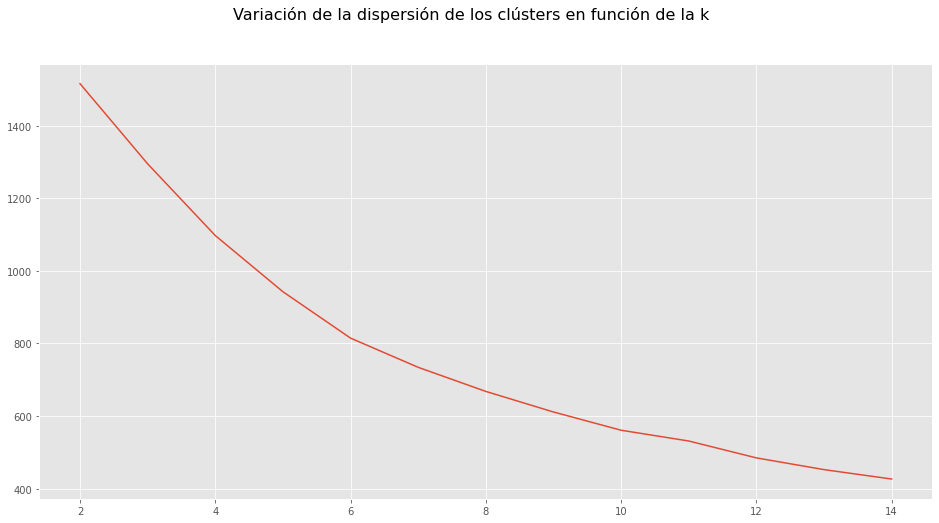

In [ ]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

De nuevo la curba no acaba de hacer forma de codo. De nuevo escogemos el número de clusters = 4 para nustro análisis.


In [ ]:
# Creamos de nuevo el pipeline usando 4 clusters

n_clusters = 4

pipe = Pipeline(steps = [
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = cols_to_filter)),
    ("StandardScaler", StandardScaler()),
    ("Clustering", KMeans(n_clusters = n_clusters, random_state=62))
])




In [ ]:
df_final.shape

(226, 10)

In [ ]:
pipe.fit(df_final)

Pipeline(steps=[('ArrayToDataFrame',
                 ArrayToDataFrame(columns=['Burning - Crop residues',
                                           'Crop Residues',
                                           'Drained organic soils',
                                           'Enteric Fermentation',
                                           'Manure Management',
                                           'Manure applied to Soils',
                                           'Manure left on Pasture',
                                           'On-farm energy use',
                                           'Rice Cultivation',
                                           'Synthetic Fertilizers'],
                                  index=['Afghanistan', 'Albania', 'Algeria',
                                         'American Samoa', 'Andorra', 'Angola',
                                         'Angu...
                ('OutlierFilter',
                 OutlierFilter(col_to_filter=['Burning -

In [ ]:
# creamos un dataframe escalado con los pasos 1, 3 y 5
X_processed = pipe[:1].transform(df_final)
X_scaled = pipe["StandardScaler"].transform(X_processed)

X_scaled.shape

(226, 10)

In [ ]:
# hacemos el predict, en este caso tendremos para cada cliente su centroide/clúster.
labels = pipe["Clustering"].predict(X_scaled)

(array([ 22., 151.,  36.,  17.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <a list of 4 Patch objects>)

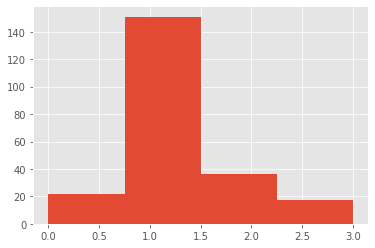

In [ ]:
# cuantos hay de cada grupo

plt.hist(labels,bins=n_clusters)

In [ ]:
# le asignamos al DataFrame procesado los centroides. (antes del escalado de variable)
# SI LO HACEMOS AL ESCALADO LOS NÚMEROS PERDERAN SU SIGNIFICADO ESCALA Y SERÁN MÁS DÍFICILES DE INTERPRETAR.
X_processed["cluster"] = labels

In [ ]:
X_processed.shape

(226, 11)

In [ ]:
X_processed.columns

Index(['Burning - Crop residues', 'Crop Residues', 'Drained organic soils',
       'Enteric Fermentation', 'Manure Management', 'Manure applied to Soils',
       'Manure left on Pasture', 'On-farm energy use', 'Rice Cultivation',
       'Synthetic Fertilizers', 'cluster'],
      dtype='object')

Burning - Crop residues
Crop Residues
Drained organic soils
Enteric Fermentation
Manure Management
Manure applied to Soils
Manure left on Pasture
On-farm energy use
Rice Cultivation
Synthetic Fertilizers


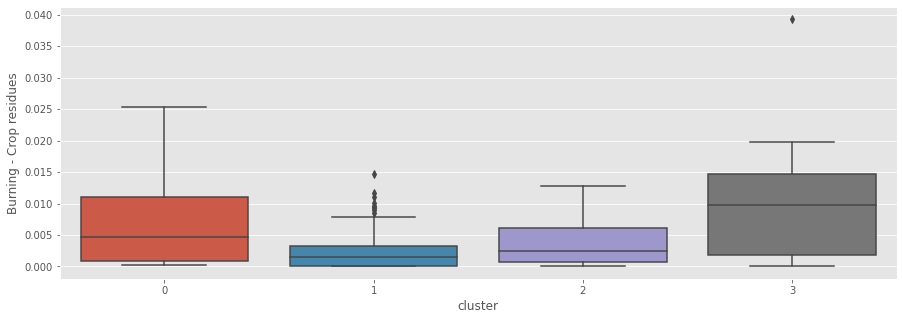

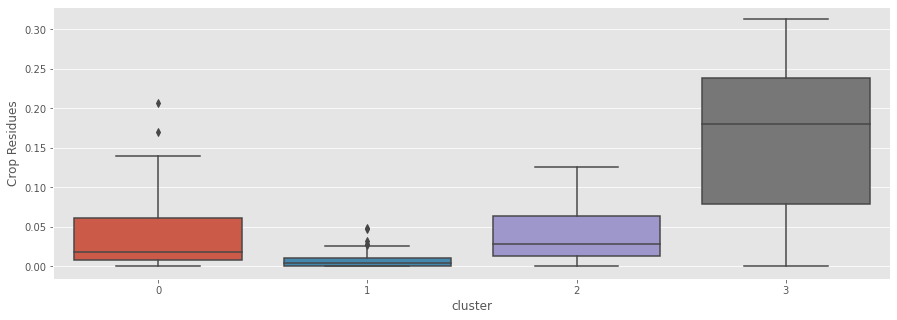

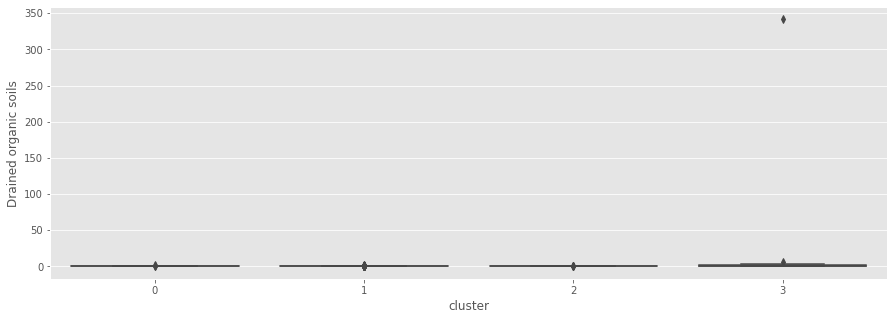

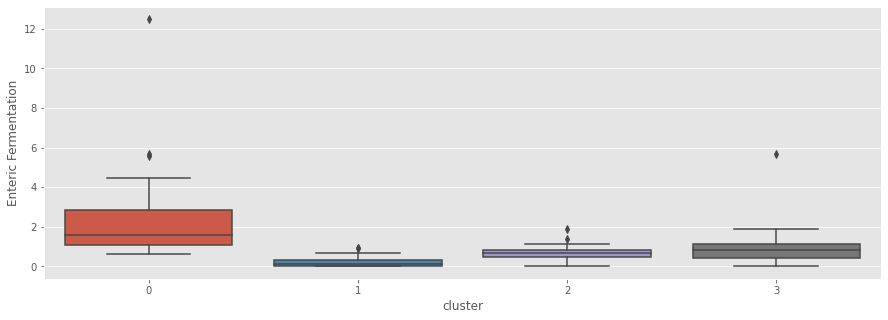

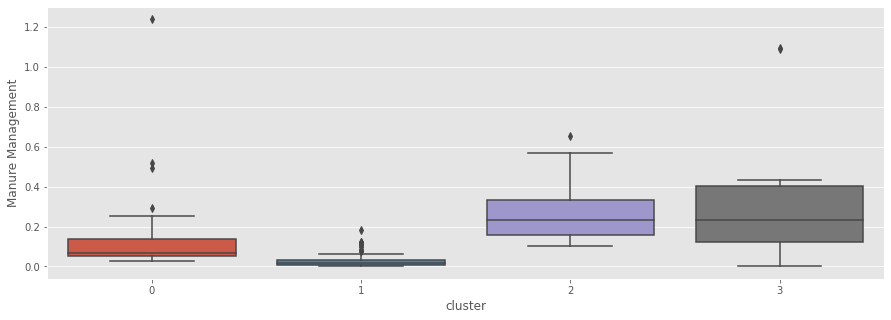

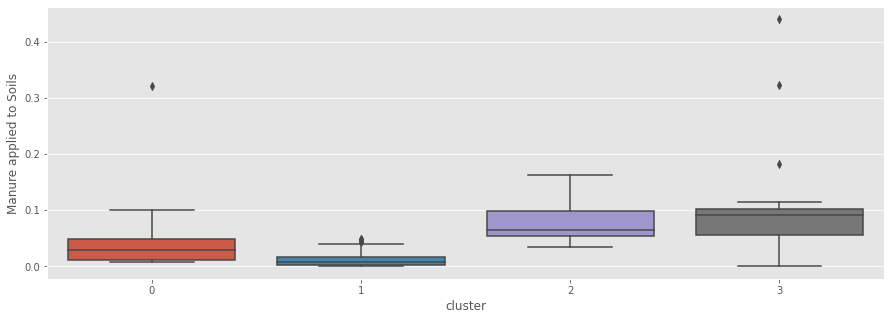

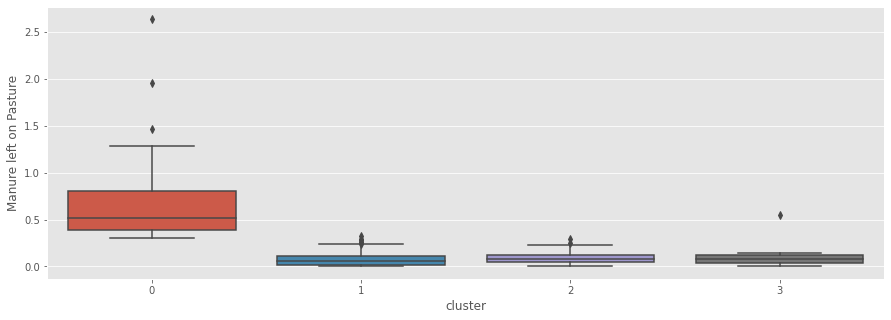

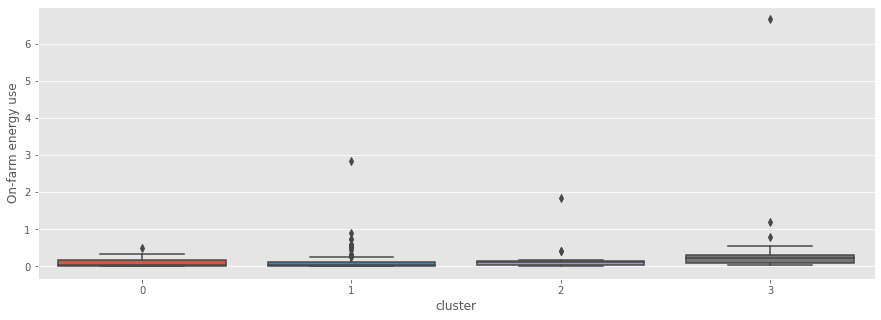

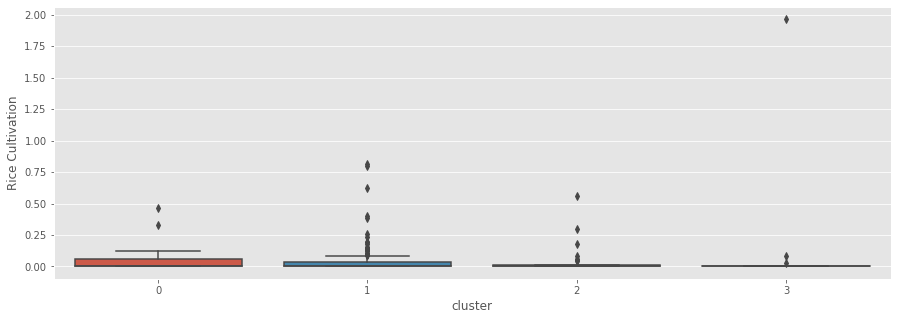

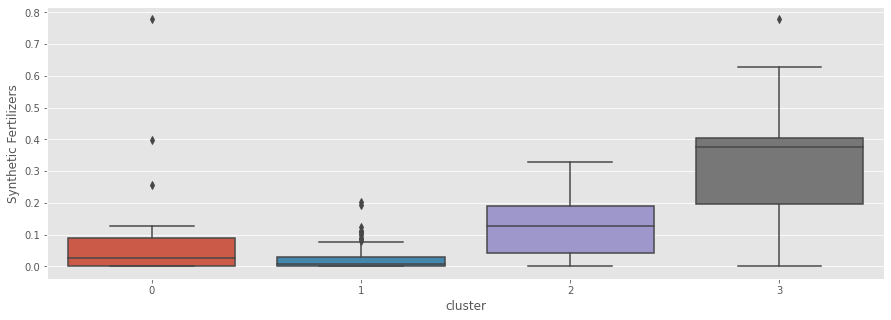

In [ ]:
# visualizamos de una forma rápida en qué variables los clusters se diferencian de los demás.

for col in X_processed.columns[:-1]:
  print(col)
  plt.figure(figsize=(15,5))
  sns.boxplot(
    data = X_processed, 
    x = 'cluster',
    y = col
)



In [ ]:
X_processed.columns

Index(['Burning - Crop residues', 'Crop Residues', 'Drained organic soils',
       'Enteric Fermentation', 'Manure Management', 'Manure applied to Soils',
       'Manure left on Pasture', 'On-farm energy use', 'Rice Cultivation',
       'Synthetic Fertilizers', 'cluster'],
      dtype='object')

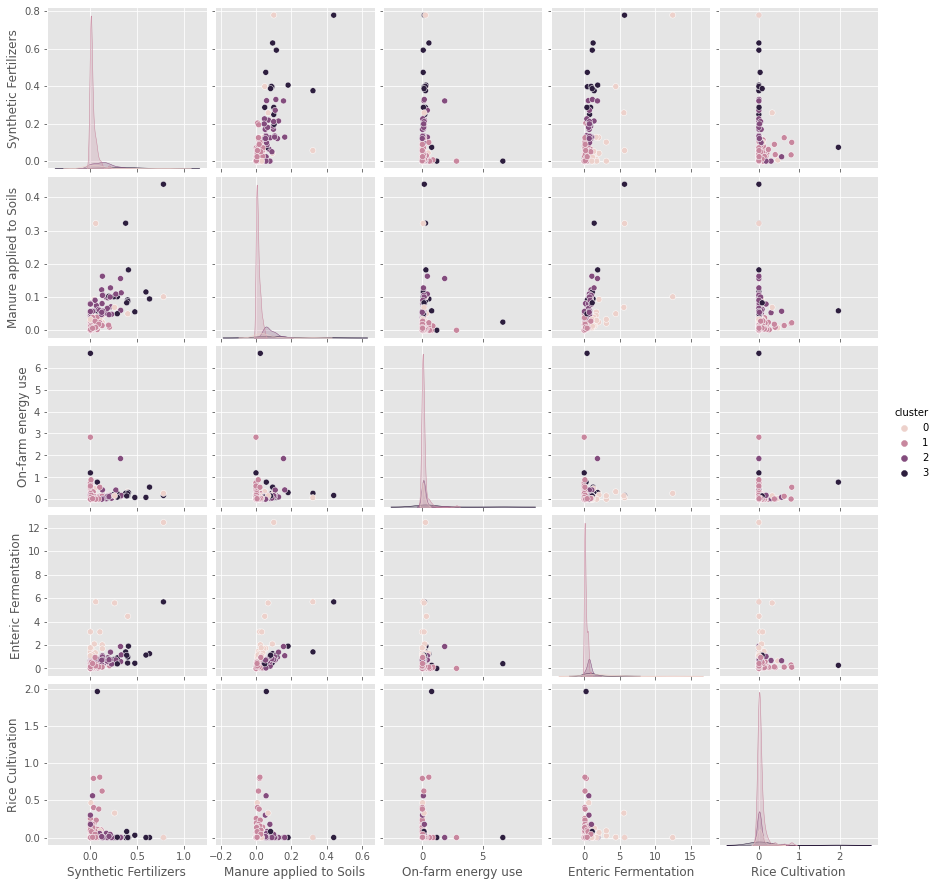

In [ ]:
# visualizamos nuestros grupos en base a las variables del modelo RFM, para ver rápiamente diferencias entre clusters de una forma más compacta que la anterior.

selected_columns = ['Synthetic Fertilizers', 'Manure applied to Soils', 'On-farm energy use','Enteric Fermentation','Rice Cultivation']

sns.pairplot(X_processed, vars = selected_columns, hue = 'cluster');

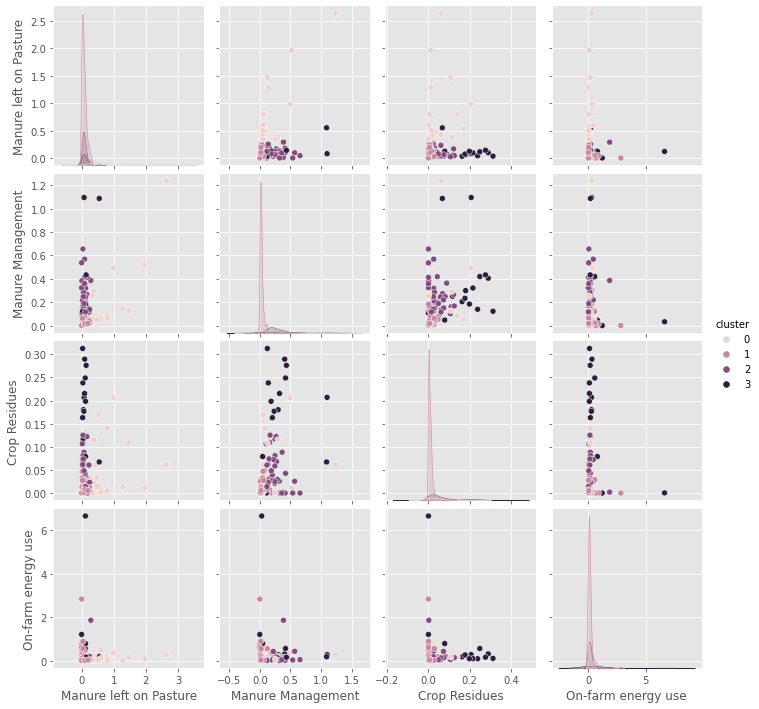

In [ ]:
selected_columns = ['Manure left on Pasture', 'Manure Management', 'Crop Residues','On-farm energy use']

sns.pairplot(X_processed, vars = selected_columns, hue = 'cluster');

Comentarios:
La mayoría de países se han agrupado en el cluster 1 (2 terceras partes del total aproximadamente)
- Grupo 0: países que más emisiones per cápita tienen por fermentación entérica y por estiercol dejado en los pastos. Países con mucha ganadería per cápita.
- Grupo 1: es el más numeroso. Son países con pocas emisiones debidas a la gestión del estiercol en comparación con el grupo 2 y 3. Tampoco tiene emisiones por fermentación entérica o emisiones por estiércol dejado en las pasturas. Es decir, son países con especialmente poco dedicados a la ganadería. Las emisiones debidas a procesos relacionados con las cosechas como uso de fertilizantes, restos de cosechas o aplicación de estiercol a la tierra son también bajas per cápita.
- Los grupos 2 y 3 generan más gases que el resto por la gestión del estiércol y su posterior aplicación en los campos de cultivo. Sin embargo, estos dos grupos se diferencian entre si porque el grupo 2 no emite tanto por uso de fertilizantes, ni por los residuos de las cosechas. El grupo 3 es el que más emite de todos por estos dos conceptos. 


### Caracterización.

#### PIB per Cápita

In [ ]:
# HAcemos un merge del PIB per cápita del año 2019

AÑO_CLUSTER = 2019
df_PIB_Dol_Cap_2019 = df_PIB_Dol_Cap[df_PIB_Dol_Cap["Year"] == AÑO_CLUSTER][["Area", "Value"]]

print(X_processed.shape)
X_processed = pd.merge(X_processed.reset_index(), df_PIB_Dol_Cap_2019, left_on="index", right_on= "Area", how="left")
print(X_processed.shape)

(226, 11)
(226, 14)


In [ ]:
X_processed.head()

,index,Burning - Crop residues,Crop Residues,Drained organic soils,Enteric Fermentation,Manure Management,Manure applied to Soils,Manure left on Pasture,On-farm energy use,Rice Cultivation,Synthetic Fertilizers,cluster,Area,Value
0,Afghanistan,0.002722,0.010390,0.000000,0.286800,0.021774,0.010802,0.070040,0.003378,0.013141,0.013734,1,Afghanistan,469.919090
1,Albania,0.002552,0.012972,0.043849,0.607033,0.150951,0.061848,0.110962,0.122772,0.000000,0.068215,2,Albania,5303.197823
2,Algeria,0.001731,0.010273,0.000000,0.170560,0.008441,0.003368,0.090174,0.008464,0.000021,0.008997,1,Algeria,3975.510381
3,American Samoa,0.000036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,NaN,NaN
4,Andorra,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269205,0.000000,0.000000,1,Andorra,40887.421647


In [ ]:
# Cambiamos el nombre de la columna que tiene la información del PIB
X_processed = X_processed.rename(columns={"Value": "PIB_Cap"})
X_processed.head()

,index,Burning - Crop residues,Crop Residues,Drained organic soils,Enteric Fermentation,Manure Management,Manure applied to Soils,Manure left on Pasture,On-farm energy use,Rice Cultivation,Synthetic Fertilizers,cluster,Area,PIB_Cap
0,Afghanistan,0.002722,0.010390,0.000000,0.286800,0.021774,0.010802,0.070040,0.003378,0.013141,0.013734,1,Afghanistan,469.919090
1,Albania,0.002552,0.012972,0.043849,0.607033,0.150951,0.061848,0.110962,0.122772,0.000000,0.068215,2,Albania,5303.197823
2,Algeria,0.001731,0.010273,0.000000,0.170560,0.008441,0.003368,0.090174,0.008464,0.000021,0.008997,1,Algeria,3975.510381
3,American Samoa,0.000036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,NaN,NaN
4,Andorra,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269205,0.000000,0.000000,1,Andorra,40887.421647


In [ ]:
# Comprobamos si todos los países tienen asignado un PIB
X_processed.isnull().sum()

index                       0
Burning - Crop residues     0
Crop Residues               0
Drained organic soils       0
Enteric Fermentation        0
Manure Management           0
Manure applied to Soils     0
Manure left on Pasture      0
On-farm energy use          0
Rice Cultivation            0
Synthetic Fertilizers       0
cluster                     0
Area                       19
PIB_Cap                    19
dtype: int64

In [ ]:
# Borramos las Areas sin PIB

X_processed.dropna(inplace=True)

In [ ]:
# Número de países definitivo para la caracterización

X_processed.shape

(207, 14)

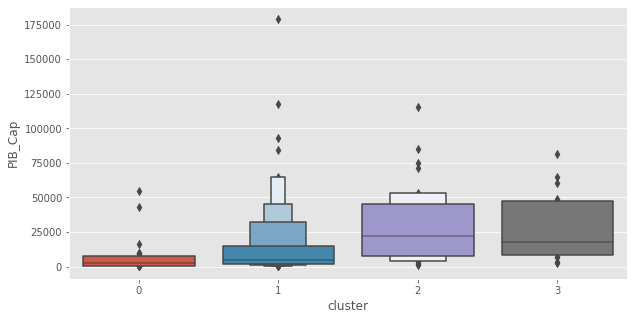

In [ ]:
plt.figure(figsize=(10,5))
sns.boxenplot(
    data = X_processed, 
    x = 'cluster',
    y = "PIB_Cap"
)


En la caracterizacion por PIB vemos que básicamente es el cluster 0, que tenían mucha ganadería, tiene el PIB bajo. (entre ellos Argentia, Brasil con alguna excepcion). Los otros clusters agrupan paises con el resto de PIBs, aunque el cluster 1, el más numeroso, contiene países también con PIB bajo pero en este caso no ganaderos.

In [ ]:
# Guardamos  el dataset con los clusters para ser usada en la parte de Time Series

X_processed[["index","cluster"]].rename(columns={"index": "Area"}).to_csv("Cluster_Paises_Emis_Totales_4_clusters.csv")

#### Anexo I Kioto
Vemos si cada cluster se puede caracterizar con la informacion de paises den el Anexo I de Kyoto

In [ ]:
a = df_emis_tot[["Area Code", "Area"]].drop_duplicates()
print(a.shape)
a = pd.merge(a,df_paises_Kyoto, on="Area Code", how="left")
print(a.shape)

(280, 2)
(280, 4)


In [ ]:
df_paises_Kyoto.head()

Country Group,Area Code,Country,Annex I countries
0,1,Armenia,0.0
1,2,Afghanistan,0.0
2,3,Albania,0.0
3,4,Algeria,0.0
4,5,American Samoa,1.0


In [ ]:
a.head(5)

,Area Code,Area,Country,Annex I countries
0,2,Afghanistan,Afghanistan,0.0
1,3,Albania,Albania,0.0
2,4,Algeria,Algeria,0.0
3,5,American Samoa,American Samoa,1.0
4,6,Andorra,Andorra,0.0


In [ ]:
# hacemos merge con la información del Anexo I

print(X_processed.shape)
X_processed = pd.merge(X_processed, a, left_on="index", right_on= "Area", how="left")
print(X_processed.shape)

(207, 14)
(207, 18)


In [ ]:
X_processed.head(1)

,index,Burning - Crop residues,Crop Residues,Drained organic soils,Enteric Fermentation,Manure Management,Manure applied to Soils,Manure left on Pasture,On-farm energy use,Rice Cultivation,Synthetic Fertilizers,cluster,Area_x,PIB_Cap,Area Code,Area_y,Country,Annex I countries
0,Afghanistan,0.002722,0.01039,0.0,0.2868,0.021774,0.010802,0.07004,0.003378,0.013141,0.013734,1,Afghanistan,469.91909,2,Afghanistan,Afghanistan,0.0


In [ ]:
X_processed.drop(["Area_y","Country"], axis="columns", inplace = True)
X_processed.head(1)

,index,Burning - Crop residues,Crop Residues,Drained organic soils,Enteric Fermentation,Manure Management,Manure applied to Soils,Manure left on Pasture,On-farm energy use,Rice Cultivation,Synthetic Fertilizers,cluster,Area_x,PIB_Cap,Area Code,Annex I countries
0,Afghanistan,0.002722,0.01039,0.0,0.2868,0.021774,0.010802,0.07004,0.003378,0.013141,0.013734,1,Afghanistan,469.91909,2,0.0


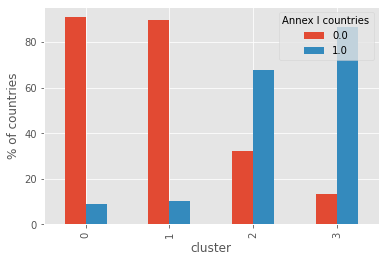

In [ ]:
plot = pd.crosstab(index=X_processed['cluster'], columns=X_processed['Annex I countries']).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar', ylabel="% of countries")


A destacar en esta clusterización que también se una relación bastante fuerte con el hecho de pertenecer o no en el Anexo I de Kioto. El cluster 1, que agrupa dos terceras partes de los países, logra recoger muchos de los países que no están en el Anexo 1, así como el cluster 0. Curiosamente los grupos 0 i 1 tienen un uso de fertilizantes bajo y poca aplicación de estiercol al campo, son los grupos donde hay menos adheridos al tratado.

Aunque no aparece el código en este Notebook, se ha hecho también una clusterización con 6 clusters usando los datos de esta tabla de emisiones totales. Esta última clusterización se ha exportado también a un fichero csv para ser usado en la parte de Time series.

##CONCLUSIONES:
Se han creado varias clusterizaciones usando diferentes tipos de datos disponibles, dando lugar a agrupaciones de países con características comunes según las emisiones per cápita en varios procesos, tanto de la cadena de suministro como en procesos en agricultura y ganadería. También se ha hecho una clusterización en base a la tabla de “Balance de alimentos” que contiene las cantidades de alimentos producidas, importadas y exportadas y su uso (alimentación humana, animal, etc).

Se ha hecho una caracterización de dichos clusters en base al PIB de los países y a su petenencia al Anexo I de Kioto. La primera clusterización en base a emisiones emitidas por sector han dado lugar a una clusterización que separa bien los países según su PIB per cápita. Los clústers con países con PIB más alto son los que desprenden más CO2 por la venta de alimentos al por menor y también algo más que el resto en emisiones debidas a la energía en sus sistema agroalimentarios. Los países que más deforestan, son de PIB bajo. En un cuarto clúster se han agrupado los países con el PIB menor.

Por otro lado, la segunda y tercera clusterización, que usaba datos de producción de alimentos y su uso, y las emisiones en los procesos agrícolas y ganaderos respectivamente, ha dado lugar a clústeres que se relacionan con la pertenencia o no en el Anexo I de Kioto.
Según esta caracterización, los países que están en el Anexo I de Kioto, están entre los más exportadores y consumidores de alimentos per cápita, y teniendo en cuenta las emisiones en agricultura y ganadería, los países que no están en el tratado de Kioto tienen pocas emisiones derivadas de los residuos de las cosechas, de estiércol aplicado a los campos y fertilizantes sintéticos. 


Aunque para facilitar el análisis se han usado 4 clusters, dado que el objetivo principal era usar estos clusters para ayudar al algoritmo de predicción temporal que se incluye en la última parte del trabajo, se podrían realizar  pruebas con diferentes números de cluster para cada una de las clusterizaciones. En este sentido, se ha hecho una prueba con 6 clusters con los datos de las emisiones en los procesos agrícolas y su resultado se ha puesto a disposición para el algoritmo de predicción temporal.


FUTURE WORK

- Añadir nuevas variables, como podría ser la variación de emisiones entre 2019 y 2005 para ver la evolución desde que el tratado de Kioto entro en vigor.

- Crear clusters usando datos de todos los años disponibles en lugar de el último año. Se podría visualizar la evolución de los países y podría ser interesante de cara a 
